In [1]:
path = '/home/naman21266/Atul_ECG_Codes/Atul codes/codes/data/'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, regularizers, optimizers, losses, metrics, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import scipy.signal as signal
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

2024-09-28 06:09:10.699032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 06:09:10.712054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 06:09:10.715964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 06:09:10.725544: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-28 06:09:11.383760: W tensorflow/compiler/tf2

In [3]:
x_train = np.load(path + 'x_train.npy')
y_train = np.load(path + 'y_train.npy')
x_test  = np.load(path + 'x_test.npy')
y_test  = np.load(path + 'y_test.npy')

# x_train = x_train.transpose(0, 2, 1)                # transpose working correctly
# x_test  = x_test.transpose(0, 2, 1)

# x_train = x_train.reshape(19267, 12, 1000, 1)       # Added another channel
# x_test  = x_test.reshape(2163, 12, 1000, 1)

print("X_train :", x_train.shape)
print("Y_train :", y_train.shape)
print("X_test  :", x_test.shape)
print("Y_test  :", y_test.shape)
print('Data loaded')

X_train : (19267, 1000, 12)
Y_train : (19267, 5)
X_test  : (2163, 1000, 12)
Y_test  : (2163, 5)
Data loaded


In [4]:
import pandas as pd

label_cnt = {}
for i in y_train:
    key = tuple(i.tolist())
    if key not in label_cnt:
        label_cnt[key] = 1
    else:
        label_cnt[key] += 1

df = pd.DataFrame(list(label_cnt.items()), columns=['Label Combination', 'Count'])
df = df.sort_values(by='Count', ascending=False)
print(df)

   Label Combination  Count
0    (0, 0, 0, 1, 0)   8170
1    (0, 0, 1, 0, 0)   2282
2    (0, 0, 0, 0, 1)   2163
4    (1, 0, 0, 0, 0)   1525
7    (1, 0, 1, 0, 0)   1167
10   (0, 1, 0, 0, 1)    710
5    (0, 0, 1, 0, 1)    541
3    (0, 1, 0, 0, 0)    480
8    (1, 0, 0, 0, 1)    434
13   (1, 0, 0, 1, 0)    362
11   (0, 1, 1, 0, 1)    320
6    (1, 1, 0, 0, 0)    273
12   (1, 0, 1, 0, 1)    202
15   (1, 1, 0, 0, 1)    186
9    (0, 1, 1, 0, 0)    166
14   (1, 1, 1, 0, 1)    142
17   (1, 1, 1, 0, 0)    112
16   (0, 0, 0, 1, 1)     24
18   (1, 0, 0, 1, 1)      5
19   (0, 1, 0, 1, 0)      2
20   (1, 1, 1, 1, 0)      1


In [5]:
import wfdb
import numpy as np

record = wfdb.rdrecord('/home/naman21266/Codes/Noise_MIT/em')
record1 = wfdb.rdrecord('/home/naman21266/Codes/Noise_MIT/bw')
record2 = wfdb.rdrecord('/home/naman21266/Codes/Noise_MIT/ma')
noise_signal_em = record.p_signal
noise_signal_bw = record1.p_signal
noise_signal_ma = record2.p_signal

# Inspect the shape of the noise signal
print(f"Noise signal-EM shape: {noise_signal_em.shape}")
print(f"Noise signal-BW shape: {noise_signal_bw.shape}")
print(f"Noise signal-MA shape: {noise_signal_ma.shape}")

Noise signal-EM shape: (650000, 2)
Noise signal-BW shape: (650000, 2)
Noise signal-MA shape: (650000, 2)


In [6]:
import scipy.signal as signal

# Function to downsample the noise signals
def downsample_signal(noise_signal, original_rate, target_rate):
    downsample_factor = int(original_rate // target_rate)
    return signal.decimate(noise_signal, downsample_factor, axis=0)

# Assuming the original sampling rate is 360 Hz, and target is 100 Hz
original_rate = 360
target_rate = 100

# Downsample the EM, BW, and MA signals
downsampled_em = downsample_signal(noise_signal_em, original_rate, target_rate)
downsampled_bw = downsample_signal(noise_signal_bw, original_rate, target_rate)
downsampled_ma = downsample_signal(noise_signal_ma, original_rate, target_rate)

noise_signal_em = downsampled_em
noise_signal_bw = downsampled_bw
noise_signal_ma = downsampled_ma

# Print the new shape of the downsampled signals
print(downsampled_em.shape)
print(downsampled_bw.shape)
print(downsampled_ma.shape)

(216667, 2)
(216667, 2)
(216667, 2)


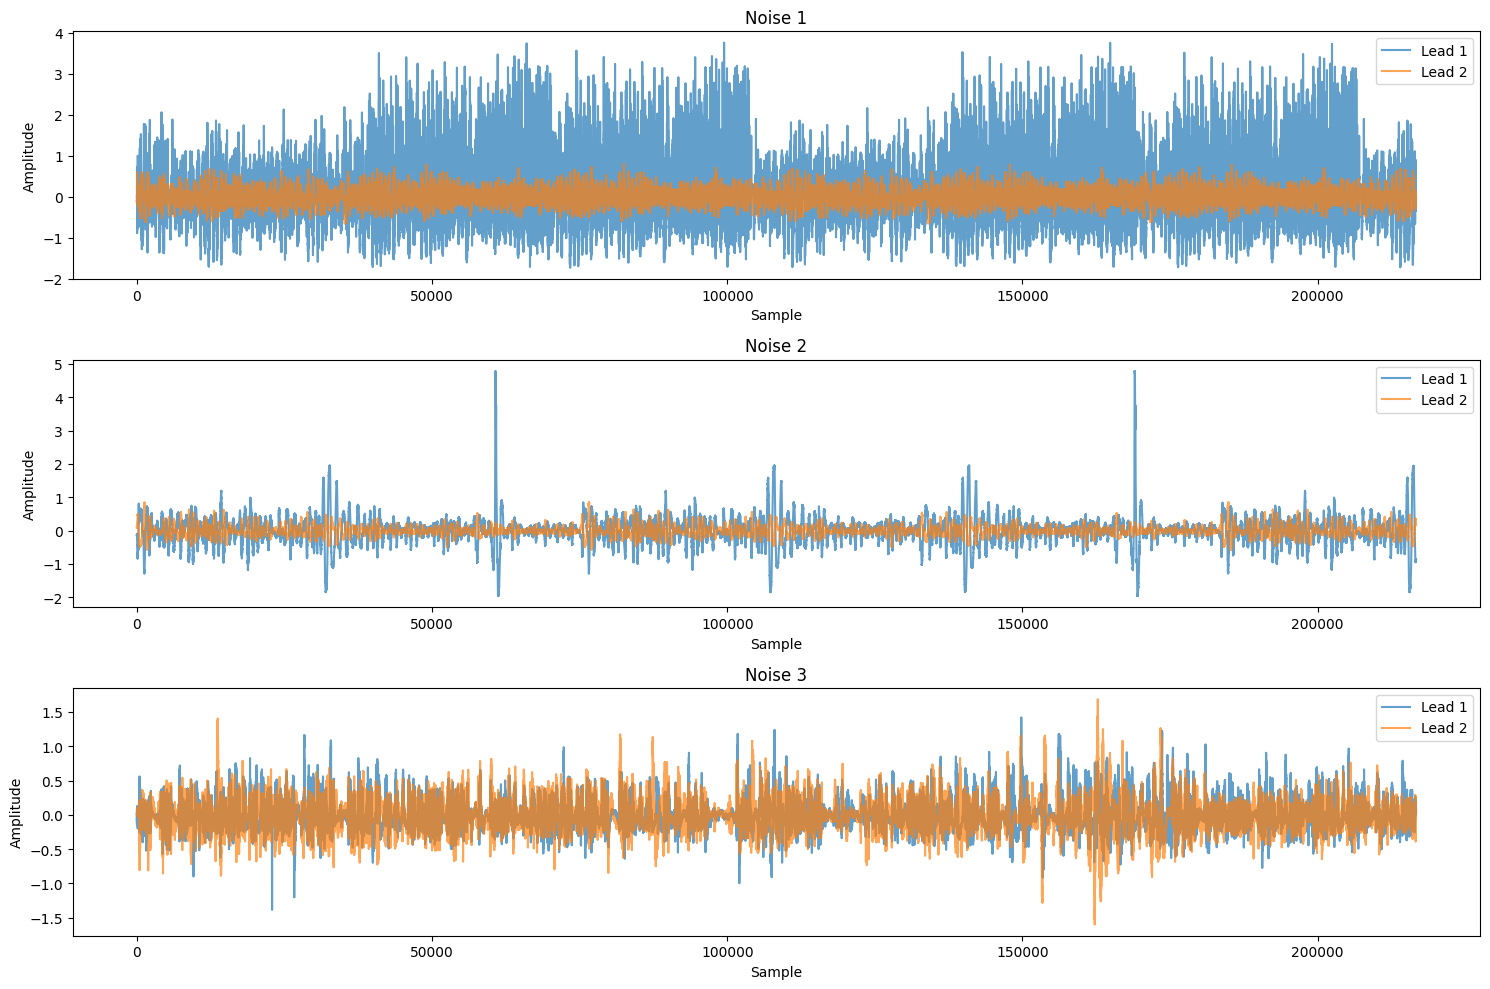

In [7]:
# Plotting the noises
plt.figure(figsize=(15, 10))

# Plot for Noise 1
plt.subplot(3, 1, 1)
plt.plot(noise_signal_em[:, 0], label='Lead 1', alpha=0.7)
plt.plot(noise_signal_em[:, 1], label='Lead 2', alpha=0.7)
plt.title('Noise 1')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

# Plot for Noise 2
plt.subplot(3, 1, 2)
plt.plot(noise_signal_bw[:, 0], label='Lead 1', alpha=0.7)
plt.plot(noise_signal_bw[:, 1], label='Lead 2', alpha=0.7)
plt.title('Noise 2')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

# Plot for Noise 3
plt.subplot(3, 1, 3)
plt.plot(noise_signal_ma[:, 0], label='Lead 1', alpha=0.7)
plt.plot(noise_signal_ma[:, 1], label='Lead 2', alpha=0.7)
plt.title('Noise 3')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Checking the Self Attention Class
import torch
import torch.nn as nn

class SelfAttention1D(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention1D, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.size, self.channels)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.view(-1, self.channels, self.size)

# Example usage:
# Input: batch of ECG samples, each of shape [1000, 12]
# Test SelfAttention1D
batch_size = 32
channels = 12
sequence_length = 1000

# Random input data
x = torch.randn(batch_size, channels, sequence_length)

# Initialize and test SelfAttention1D
attention_layer = SelfAttention1D(channels=channels, size=sequence_length)
output = attention_layer(x)
print(f"SelfAttention1D Output Shape: {output.shape}")  # Expected: (batch_size, channels, sequence_length)



SelfAttention1D Output Shape: torch.Size([32, 12, 1000])


In [9]:
# Checking the Double1D Conv Class
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(DoubleConv1D, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv1d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

# Example usage:
# Input: batch of ECG samples, each of shape [12, 1000] (12 leads, 1000 time steps)
# Test DoubleConv1D
batch_size = 32
in_channels = 12
out_channels = 12
sequence_length = 1000

# Random input data
x = torch.randn(batch_size, in_channels, sequence_length)

# Initialize and test DoubleConv1D
double_conv_layer = DoubleConv1D(in_channels, out_channels)
output = double_conv_layer(x)
print(f"DoubleConv1D Output Shape: {output.shape}")  # Expected: (batch_size, out_channels, sequence_length)



DoubleConv1D Output Shape: torch.Size([32, 12, 1000])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(DoubleConv1D, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv1d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        print(f"Input shape: {x.shape}")  # Print the input shape
        
        # First convolution layer
        x = self.double_conv[0](x)
        print(f"After first Conv1d: {x.shape}")
        
        # First GroupNorm
        x = self.double_conv[1](x)
        print(f"After first GroupNorm: {x.shape}")
        
        # GELU activation
        x = self.double_conv[2](x)
        print(f"After GELU: {x.shape}")
        
        # Second convolution layer
        x = self.double_conv[3](x)
        print(f"After second Conv1d: {x.shape}")
        
        # Second GroupNorm
        x = self.double_conv[4](x)
        print(f"After second GroupNorm: {x.shape}")

        # Residual connection if applicable
        if self.residual:
            x += x
            print(f"After adding residual: {x.shape}")

        return x
batch_size = 32
in_channels = 12
out_channels = 64
sequence_length = 1000

# Random input data
x = torch.randn(batch_size, in_channels, sequence_length)

# Initialize and test DoubleConv1D
double_conv_layer = DoubleConv1D(in_channels, out_channels)
output = double_conv_layer(x)
print(f"DoubleConv1D Output Shape: {output.shape}")  # Expected: (batch_size, out_channels, sequence_length)


Input shape: torch.Size([32, 12, 1000])
After first Conv1d: torch.Size([32, 64, 1000])
After first GroupNorm: torch.Size([32, 64, 1000])
After GELU: torch.Size([32, 64, 1000])
After second Conv1d: torch.Size([32, 64, 1000])
After second GroupNorm: torch.Size([32, 64, 1000])
DoubleConv1D Output Shape: torch.Size([32, 64, 1000])


In [11]:
# Checking the Down Class:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(DoubleConv1D, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv1d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down1D(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(Down1D, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv1D(in_channels, in_channels, residual=True),
            DoubleConv1D(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)  # Apply max pooling and convolutions
        emb = self.emb_layer(t)[:, :, None].repeat(1, 1, x.shape[-1])  # Adjust embedding shape to match time dimension
        return x + emb  # Add the embedding to the feature maps

# Example usage:
# Input: batch of ECG samples, each of shape [12, 1000] (12 leads, 1000 time steps)
# Test Down1D
batch_size = 32
in_channels = 12
out_channels = 64
sequence_length = 1000

# Random input data
x = torch.randn(batch_size, in_channels, sequence_length)
t = torch.randn(batch_size, 256)  # Random time embedding vector

# Initialize and test Down1D
down_layer = Down1D(in_channels, out_channels)
output = down_layer(x, t)
print(f"Down1D Output Shape: {output.shape}")  # Expected: (batch_size, out_channels, sequence_length // 2)


Down1D Output Shape: torch.Size([32, 64, 500])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, residual=False):
        super(DoubleConv1D, self).__init__()
        self.residual = residual
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.GELU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
        )
    
    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Up1D(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(Up1D, self).__init__()
        
        # Adjust the in_channels for concatenation
        self.conv = DoubleConv1D(in_channels * 2, out_channels)
        
        # Embedding layer for the time embedding
        self.emb_layer = nn.Sequential(
            nn.GELU(),
            nn.Linear(emb_dim, out_channels)
        )
    
    def forward(self, x, skip_x, t):
        # Upsample input x
        x = F.interpolate(x, scale_factor=2, mode='linear', align_corners=False)
        
        # Concatenate skip_x and x along the channel dimension
        x = torch.cat([skip_x, x], dim=1)
        
        # Pass through convolution layers
        x = self.conv(x)
        
        # Add timestep embedding
        emb = self.emb_layer(t)[:, :, None].repeat(1, 1, x.shape[-1])
        x = x + emb
        
        return x
# Dummy input data
batch_size = 32
in_channels = 64
out_channels = 64
emb_dim = 256
seq_len = 500
skip_seq_len = 1000

# Initialize inputs
x = torch.randn(batch_size, in_channels, seq_len)        # Input tensor
skip_x = torch.randn(batch_size, in_channels, skip_seq_len)  # Skip connection tensor
t = torch.randn(batch_size, emb_dim)  # Timestep embedding

# Initialize Up1D block
up_block = Up1D(in_channels=in_channels, out_channels=out_channels, emb_dim=emb_dim)

# Forward pass through the Up1D block
output = up_block(x, skip_x, t)

# Print the shape of the output
print("Output shape:", output.shape)


Output shape: torch.Size([32, 64, 1000])


In [17]:
x_train.shape

(19267, 1000, 12)

In [18]:
print(type(x_train))

<class 'numpy.ndarray'>


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class SelfAttention1D(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention1D, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.size, self.channels)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.view(-1, self.channels, self.size)


class DoubleConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv1d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down1D(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=1000):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv1D(in_channels, in_channels, residual=True),
            DoubleConv1D(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None].repeat(1, 1, x.shape[-1])
        return x + emb


class Up1D(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=1000):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="linear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv1D(in_channels, in_channels, residual=True),
            DoubleConv1D(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None].repeat(1, 1, x.shape[-1])
        return x + emb


class UNet1D(nn.Module):
    def __init__(self, c_in=12, c_out=12, time_dim=1000, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        
        self.inc = DoubleConv1D(c_in, 64)          # Input: (N, c_in=12, L=1000) -> Output: (N, 64, 1000)
        self.down1 = Down1D(64, 128)               # Input: (N, 64, 1000) -> Output: (N, 128, 500)
        self.sa1 = SelfAttention1D(128, 500)       # Input: (N, 128, 500) -> Output: (N, 128, 500)
        
        self.down2 = Down1D(128, 256)              # Input: (N, 128, 500) -> Output: (N, 256, 250)
        self.sa2 = SelfAttention1D(256, 250)       # Input: (N, 256, 250) -> Output: (N, 256, 250)
        
        self.down3 = Down1D(256, 256)              # Input: (N, 256, 250) -> Output: (N, 256, 125)
        self.sa3 = SelfAttention1D(256, 125)       # Input: (N, 256, 125) -> Output: (N, 256, 125)

        self.bot1 = DoubleConv1D(256, 512)         # Input: (N, 256, 125) -> Output: (N, 512, 125)
        self.bot2 = DoubleConv1D(512, 512)         # Input: (N, 512, 125) -> Output: (N, 512, 125)
        self.bot3 = DoubleConv1D(512, 256)         # Input: (N, 512, 125) -> Output: (N, 256, 125)

        self.up1 = Up1D(512, 128)                   # Input: (N, 256, 125) + (N, 512, 125) -> Output: (N, 128, 250)
        self.sa4 = SelfAttention1D(128, 250)       # Input: (N, 128, 250) -> Output: (N, 128, 250)
        
        self.up2 = Up1D(256, 64)                    # Input: (N, 128, 250) + (N, 256, 250) -> Output: (N, 64, 500)
        self.sa5 = SelfAttention1D(64, 500)        # Input: (N, 64, 500) -> Output: (N, 64, 500)
        
        self.up3 = Up1D(128, 64)                    # Input: (N, 64, 500) + (N, 64, 500) -> Output: (N, 64, 1000)
        self.sa6 = SelfAttention1D(64, 1000)       # Input: (N, 64, 1000) -> Output: (N, 64, 1000)
        
        self.outc = nn.Conv1d(64, c_out, kernel_size=1)  # Input: (N, 64, 1000) -> Output: (N, c_out=12, 1000)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)  # Input: (N, L=1000) -> Output: (N, 1)
        t = self.pos_encoding(t, self.time_dim) # Output: (N, time_dim=1000)

        x1 = self.inc(x)                         # Input: (N, c_in=12, L=1000) -> Output: (N, 64, 1000)
        x2 = self.down1(x1, t)                  # Input: (N, 64, 1000) -> Output: (N, 128, 500)
        x2 = self.sa1(x2)                       # Input: (N, 128, 500) -> Output: (N, 128, 500)
        
        x3 = self.down2(x2, t)                  # Input: (N, 128, 500) -> Output: (N, 256, 250)
        x3 = self.sa2(x3)                       # Input: (N, 256, 250) -> Output: (N, 256, 250)

        x4 = self.down3(x3, t)                  # Input: (N, 256, 250) -> Output: (N, 256, 125)
        x4 = self.sa3(x4)                       # Input: (N, 256, 125) -> Output: (N, 256, 125)

        x4 = self.bot1(x4)                      # Input: (N, 256, 125) -> Output: (N, 512, 125)
        x4 = self.bot2(x4)                      # Input: (N, 512, 125) -> Output: (N, 512, 125)
        x4 = self.bot3(x4)                      # Input: (N, 512, 125) -> Output: (N, 256, 125)

        x = self.up1(x4, x3, t)                  # Input: (N, 256, 125) + (N, 512, 125) -> Output: (N, 128, 250)
        x = self.sa4(x)                          # Input: (N, 128, 250) -> Output: (N, 128, 250)

        x = self.up2(x, x2, t)                   # Input: (N, 128, 250) + (N, 256, 250) -> Output: (N, 64, 500)
        x = self.sa5(x)                          # Input: (N, 64, 500) -> Output: (N, 64, 500)

        x = self.up3(x, x1, t)                   # Input: (N, 64, 500) + (N, 64, 500) -> Output: (N, 64, 1000)
        x = self.sa6(x)                          # Input: (N, 64, 1000) -> Output: (N, 64, 1000)

        output = self.outc(x)                    # Input: (N, 64, 1000) -> Output: (N, c_out=12, 1000)

        return output


batch_size = 32
time_steps = 1000
leads = 12

training_data = x_train
x_train_transposed = np.transpose(training_data, (0, 2, 1))
x_train_tensor = torch.from_numpy(x_train_transposed).float()  # Convert to float if needed

# Create a DataLoader
batch_size = 32
train_dataset = TensorDataset(x_train_tensor)  # No labels, just the data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the U-Net model
model = UNet1D(c_in=12, c_out=12, device="cpu")
model = model.to("cpu")  # Change to "cuda" if you are using GPU

# Define loss function and optimizer
criterion = nn.MSELoss()  # Assuming reconstruction loss for U-Net
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10  # Specify the number of epochs
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for batch in train_loader:
        # Get the inputs
        inputs, = batch  # Unpack the batch
        inputs = inputs.to("cpu")  # Move to GPU if available
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        t = torch.randint(0, 100, (inputs.size(0),)).to(inputs.device)  # Random time steps
        outputs = model(inputs, t)
        
        # Calculate the loss
        loss = criterion(outputs, inputs)  # Reconstruction loss
        epoch_loss += loss.item()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    # Average loss for this epoch
    avg_loss = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

print("Training completed.")

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class SelfAttention2D(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention2D, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.size, self.channels)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.view(-1, self.channels, self.size)


class DoubleConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=(3, 1), padding=0, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=(3, 1), padding=0, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down2D(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=1000):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d((2, 1)),  # No change to lead dimension
            DoubleConv2D(in_channels, in_channels, residual=True),
            DoubleConv2D(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up2D(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=1000):
        super().__init__()

        self.up = nn.Upsample(scale_factor=(2, 1), mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv2D(in_channels, in_channels, residual=True),
            DoubleConv2D(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet2D(nn.Module):
    def __init__(self, c_in=12, c_out=12, time_dim=1000, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        
        self.inc = DoubleConv2D(1, 64)          # Input: (N, 1, 1000, 12) -> Output: (N, 64, 998, 12)
        self.down1 = Down2D(64, 128)            # Input: (N, 64, 998, 12) -> Output: (N, 128, 499, 12)
        self.sa1 = SelfAttention2D(128, 499)    # Input: (N, 128, 499, 12) -> Output: (N, 128, 499, 12)
        
        self.down2 = Down2D(128, 256)           # Input: (N, 128, 499, 12) -> Output: (N, 256, 249, 12)
        self.sa2 = SelfAttention2D(256, 249)    # Input: (N, 256, 249, 12) -> Output: (N, 256, 249, 12)
        
        self.down3 = Down2D(256, 256)           # Input: (N, 256, 249, 12) -> Output: (N, 256, 124, 12)
        self.sa3 = SelfAttention2D(256, 124)    # Input: (N, 256, 124, 12) -> Output: (N, 256, 124, 12)

        self.bot1 = DoubleConv2D(256, 512)      # Input: (N, 256, 124, 12) -> Output: (N, 512, 122, 12)
        self.bot2 = DoubleConv2D(512, 512)      # Input: (N, 512, 122, 12) -> Output: (N, 512, 120, 12)
        self.bot3 = DoubleConv2D(512, 256)      # Input: (N, 512, 120, 12) -> Output: (N, 256, 118, 12)

        self.up1 = Up2D(512, 128)               # Input: (N, 256, 118, 12) + (N, 512, 249, 12) -> Output: (N, 128, 249, 12)
        self.sa4 = SelfAttention2D(128, 249)    # Input: (N, 128, 249, 12) -> Output: (N, 128, 249, 12)
        
        self.up2 = Up2D(256, 64)                # Input: (N, 128, 249, 12) + (N, 256, 499, 12) -> Output: (N, 64, 499, 12)
        self.sa5 = SelfAttention2D(64, 499)     # Input: (N, 64, 499, 12) -> Output: (N, 64, 499, 12)
        
        self.up3 = Up2D(128, 64)                # Input: (N, 64, 499, 12) + (N, 64, 998, 12) -> Output: (N, 64, 998, 12)
        self.sa6 = SelfAttention2D(64, 998)     # Input: (N, 64, 998, 12) -> Output: (N, 64, 998, 12)
        
        self.outc = nn.Conv2d(64, 1, kernel_size=(1, 1))  # Input: (N, 64, 998, 12) -> Output: (N, 1, 998, 12)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float).to(self.device)  # Input: (N, L=1000) -> Output: (N, 1)
        t = self.pos_encoding(t, self.time_dim)  # Output: (N, time_dim=1000)

        x1 = self.inc(x)  # Initial conv
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x5 = self.bot1(x4)
        x5 = self.bot2(x5)
        x5 = self.bot3(x5)

        x = self.up1(x5, x4, t)
        x = self.sa4(x)
        x = self.up2(x, x3, t)
        x = self.sa5(x)
        x = self.up3(x, x2, t)
        x = self.sa6(x)
        output = self.outc(x)

        return output

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class SelfAttention1D(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention1D, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.size, self.channels)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.view(-1, self.channels, self.size)

class DoubleConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv1d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down1D(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=1000):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv1D(in_channels, in_channels, residual=True),
            DoubleConv1D(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None].repeat(1, 1, x.shape[-1])
        return x + emb

class Up1D(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=1000):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="linear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv1D(in_channels, in_channels, residual=True),
            DoubleConv1D(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None].repeat(1, 1, x.shape[-1])
        return x + emb

class UNet1D(nn.Module):
    def __init__(self, c_in=12, c_out=12, time_dim=1000, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        
        self.inc = DoubleConv1D(c_in, 64)          # Input: (N, c_in=12, L=1000) -> Output: (N, 64, 1000)
        self.down1 = Down1D(64, 128)               # Input: (N, 64, 1000) -> Output: (N, 128, 500)
        self.sa1 = SelfAttention1D(128, 500)       # Input: (N, 128, 500) -> Output: (N, 128, 500)
        
        self.down2 = Down1D(128, 256)              # Input: (N, 128, 500) -> Output: (N, 256, 250)
        self.sa2 = SelfAttention1D(256, 250)       # Input: (N, 256, 250) -> Output: (N, 256, 250)
        
        self.down3 = Down1D(256, 256)              # Input: (N, 256, 250) -> Output: (N, 256, 125)
        self.sa3 = SelfAttention1D(256, 125)       # Input: (N, 256, 125) -> Output: (N, 256, 125)

        self.bot1 = DoubleConv1D(256, 512)         # Input: (N, 256, 125) -> Output: (N, 512, 125)
        self.bot2 = DoubleConv1D(512, 512)         # Input: (N, 512, 125) -> Output: (N, 512, 125)
        self.bot3 = DoubleConv1D(512, 256)         # Input: (N, 512, 125) -> Output: (N, 256, 125)

        self.up1 = Up1D(512, 128)                   # Input: (N, 256, 125) + (N, 512, 125) -> Output: (N, 128, 250)
        self.sa4 = SelfAttention1D(128, 250)       # Input: (N, 128, 250) -> Output: (N, 128, 250)
        
        self.up2 = Up1D(256, 64)                    # Input: (N, 128, 250) + (N, 256, 250) -> Output: (N, 64, 500)
        self.sa5 = SelfAttention1D(64, 500)        # Input: (N, 64, 500) -> Output: (N, 64, 500)
        
        self.up3 = Up1D(128, 64)                    # Input: (N, 64, 500) + (N, 64, 500) -> Output: (N, 64, 1000)
        self.sa6 = SelfAttention1D(64, 1000)       # Input: (N, 64, 1000) -> Output: (N, 64, 1000)
        
        self.outc = nn.Conv1d(64, c_out, kernel_size=1)  # Input: (N, 64, 1000) -> Output: (N, c_out=12, 1000)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float).to(self.device)  # Input: (N, L=1000) -> Output: (N, 1)
        t = self.pos_encoding(t, self.time_dim)  # Output: (N, time_dim=1000)

        x1 = self.inc(x)  # Input: (N, c_in=12, L=1000) -> Output: (N, 64, 1000)
        x2 = self.down1(x1, t)  # Input: (N, 64, 1000) -> Output: (N, 128, 500)
        x2 = self.sa1(x2)  # Input: (N, 128, 500) -> Output: (N, 128, 500)
        
        x3 = self.down2(x2, t)  # Input: (N, 128, 500) -> Output: (N, 256, 250)
        x3 = self.sa2(x3)  # Input: (N, 256, 250) -> Output: (N, 256, 250)

        x4 = self.down3(x3, t)  # Input: (N, 256, 250) -> Output: (N, 256, 125)
        x4 = self.sa3(x4)  # Input: (N, 256, 125) -> Output: (N, 256, 125)

        x4 = self.bot1(x4)  # Input: (N, 256, 125) -> Output: (N, 512, 125)
        x4 = self.bot2(x4)  # Input: (N, 512, 125) -> Output: (N, 512, 125)
        x4 = self.bot3(x4)  # Input: (N, 512, 125) -> Output: (N, 256, 125)

        x = self.up1(x4, x3, t)  # Input: (N, 256, 125) + (N, 256, 250) -> Output: (N, 128, 250)
        x = self.sa4(x)  # Input: (N, 128, 250) -> Output: (N, 128, 250)

        x = self.up2(x, x2, t)  # Input: (N, 128, 250) + (N, 128, 500) -> Output: (N, 64, 500)
        x = self.sa5(x)  # Input: (N, 64, 500) -> Output: (N, 64, 500)

        x = self.up3(x, x1, t)  # Input: (N, 64, 500) + (N, 64, 1000) -> Output: (N, 64, 1000)
        x = self.sa6(x)  # Input: (N, 64, 1000) -> Output: (N, 64, 1000)

        logits = self.outc(x)  # Output: (N, c_out=12, 1000)
        return logits

# Assuming your training data is ready as X and Y
training_data = x_train
x_train_transposed = np.transpose(training_data, (0, 2, 1))
x_train_tensor = torch.from_numpy(x_train_transposed).float()  # Convert to float if needed
X_train = x_train_tensor  # Example train data
Y_train = x_train_tensor # Example target data
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

# Convert the training data to PyTorch tensors and send them to the appropriate device
X_train_tensor = torch.tensor(X_train).to(device)
Y_train_tensor = torch.tensor(Y_train).to(device)
# Prepare the dataset and dataloader
dataset = TensorDataset(X_train_tensor, Y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create the model and send it to the appropriate device
model = UNet1D(c_in=12, c_out=12, device=device).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        output = model(x_batch, torch.randn(x_batch.size(0), device=device))  # Dummy noise tensor for t
        loss = F.mse_loss(output, y_batch)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), 'unet1d_model.pth')

cuda


/tmp/ipykernel_1095624/2033343367.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train).to(device)
/tmp/ipykernel_1095624/2033343367.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train_tensor = torch.tensor(Y_train).to(device)


Epoch [1/10], Loss: 0.0050
Epoch [2/10], Loss: 0.0062
Epoch [3/10], Loss: 0.0029
Epoch [4/10], Loss: 0.0054
Epoch [5/10], Loss: 0.0022
Epoch [6/10], Loss: 0.0029
Epoch [7/10], Loss: 0.0033
Epoch [8/10], Loss: 0.0050
Epoch [9/10], Loss: 0.0011
Epoch [10/10], Loss: 0.0015


Reconstructed sample shapes: (5, 12, 1000)


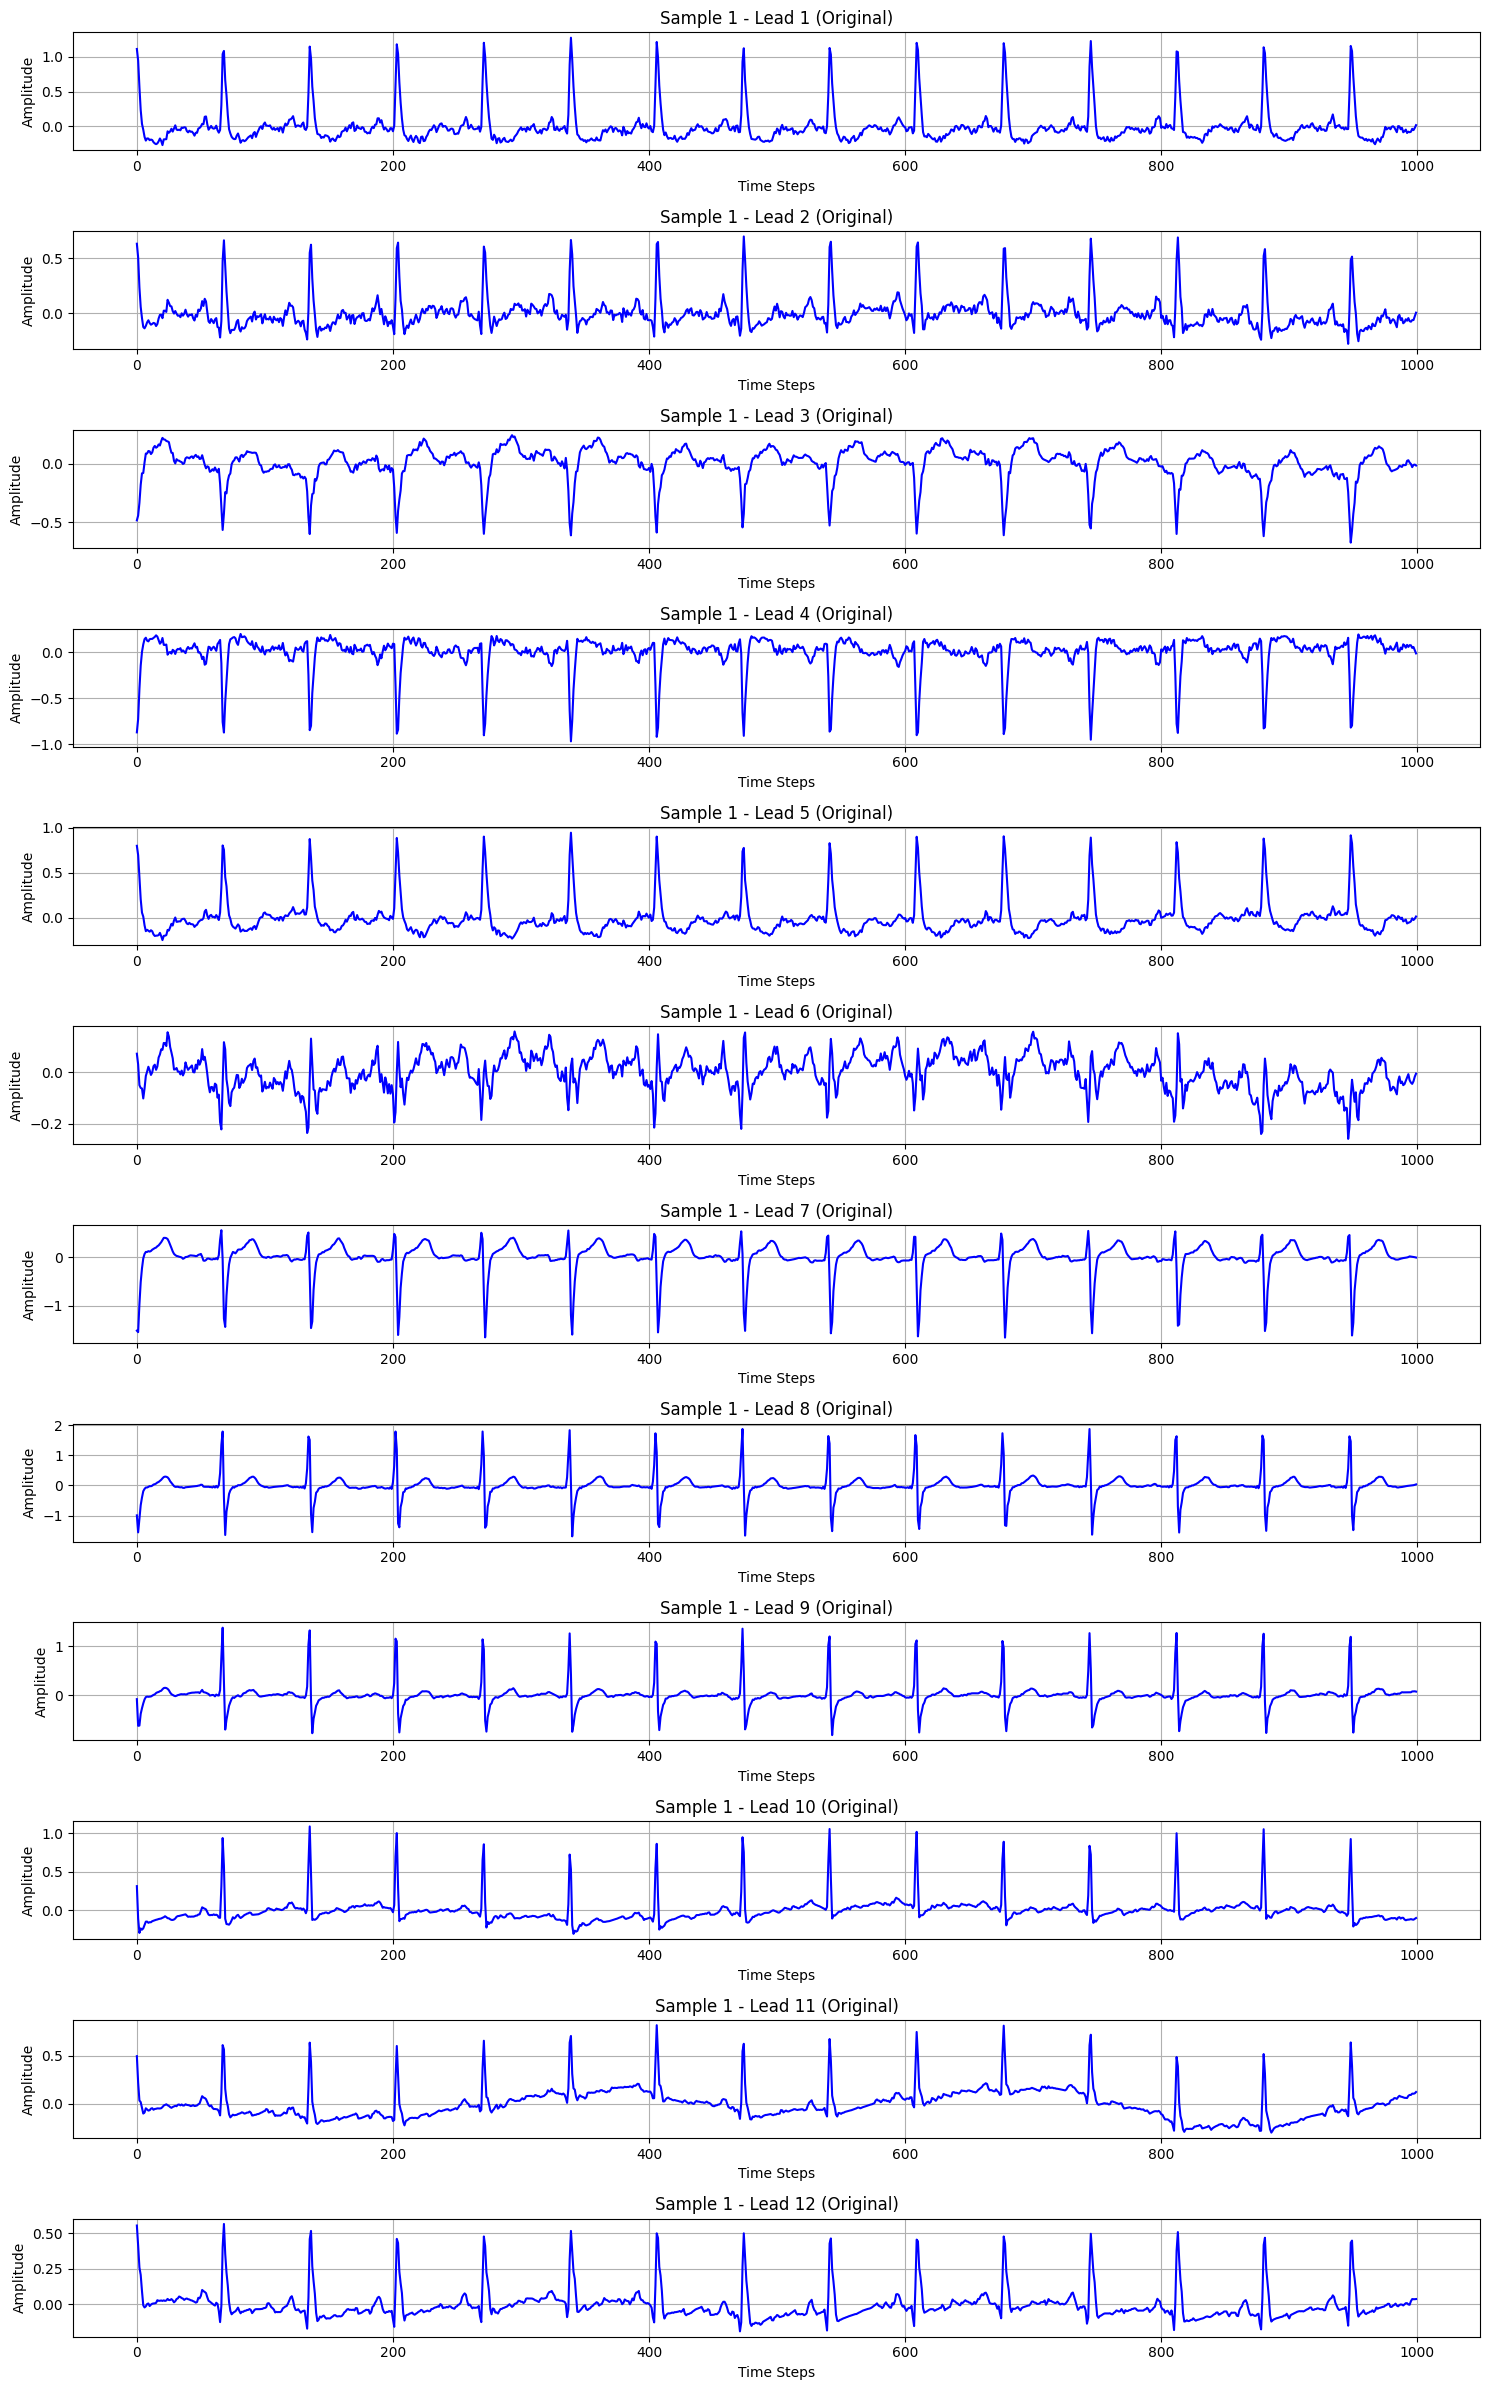

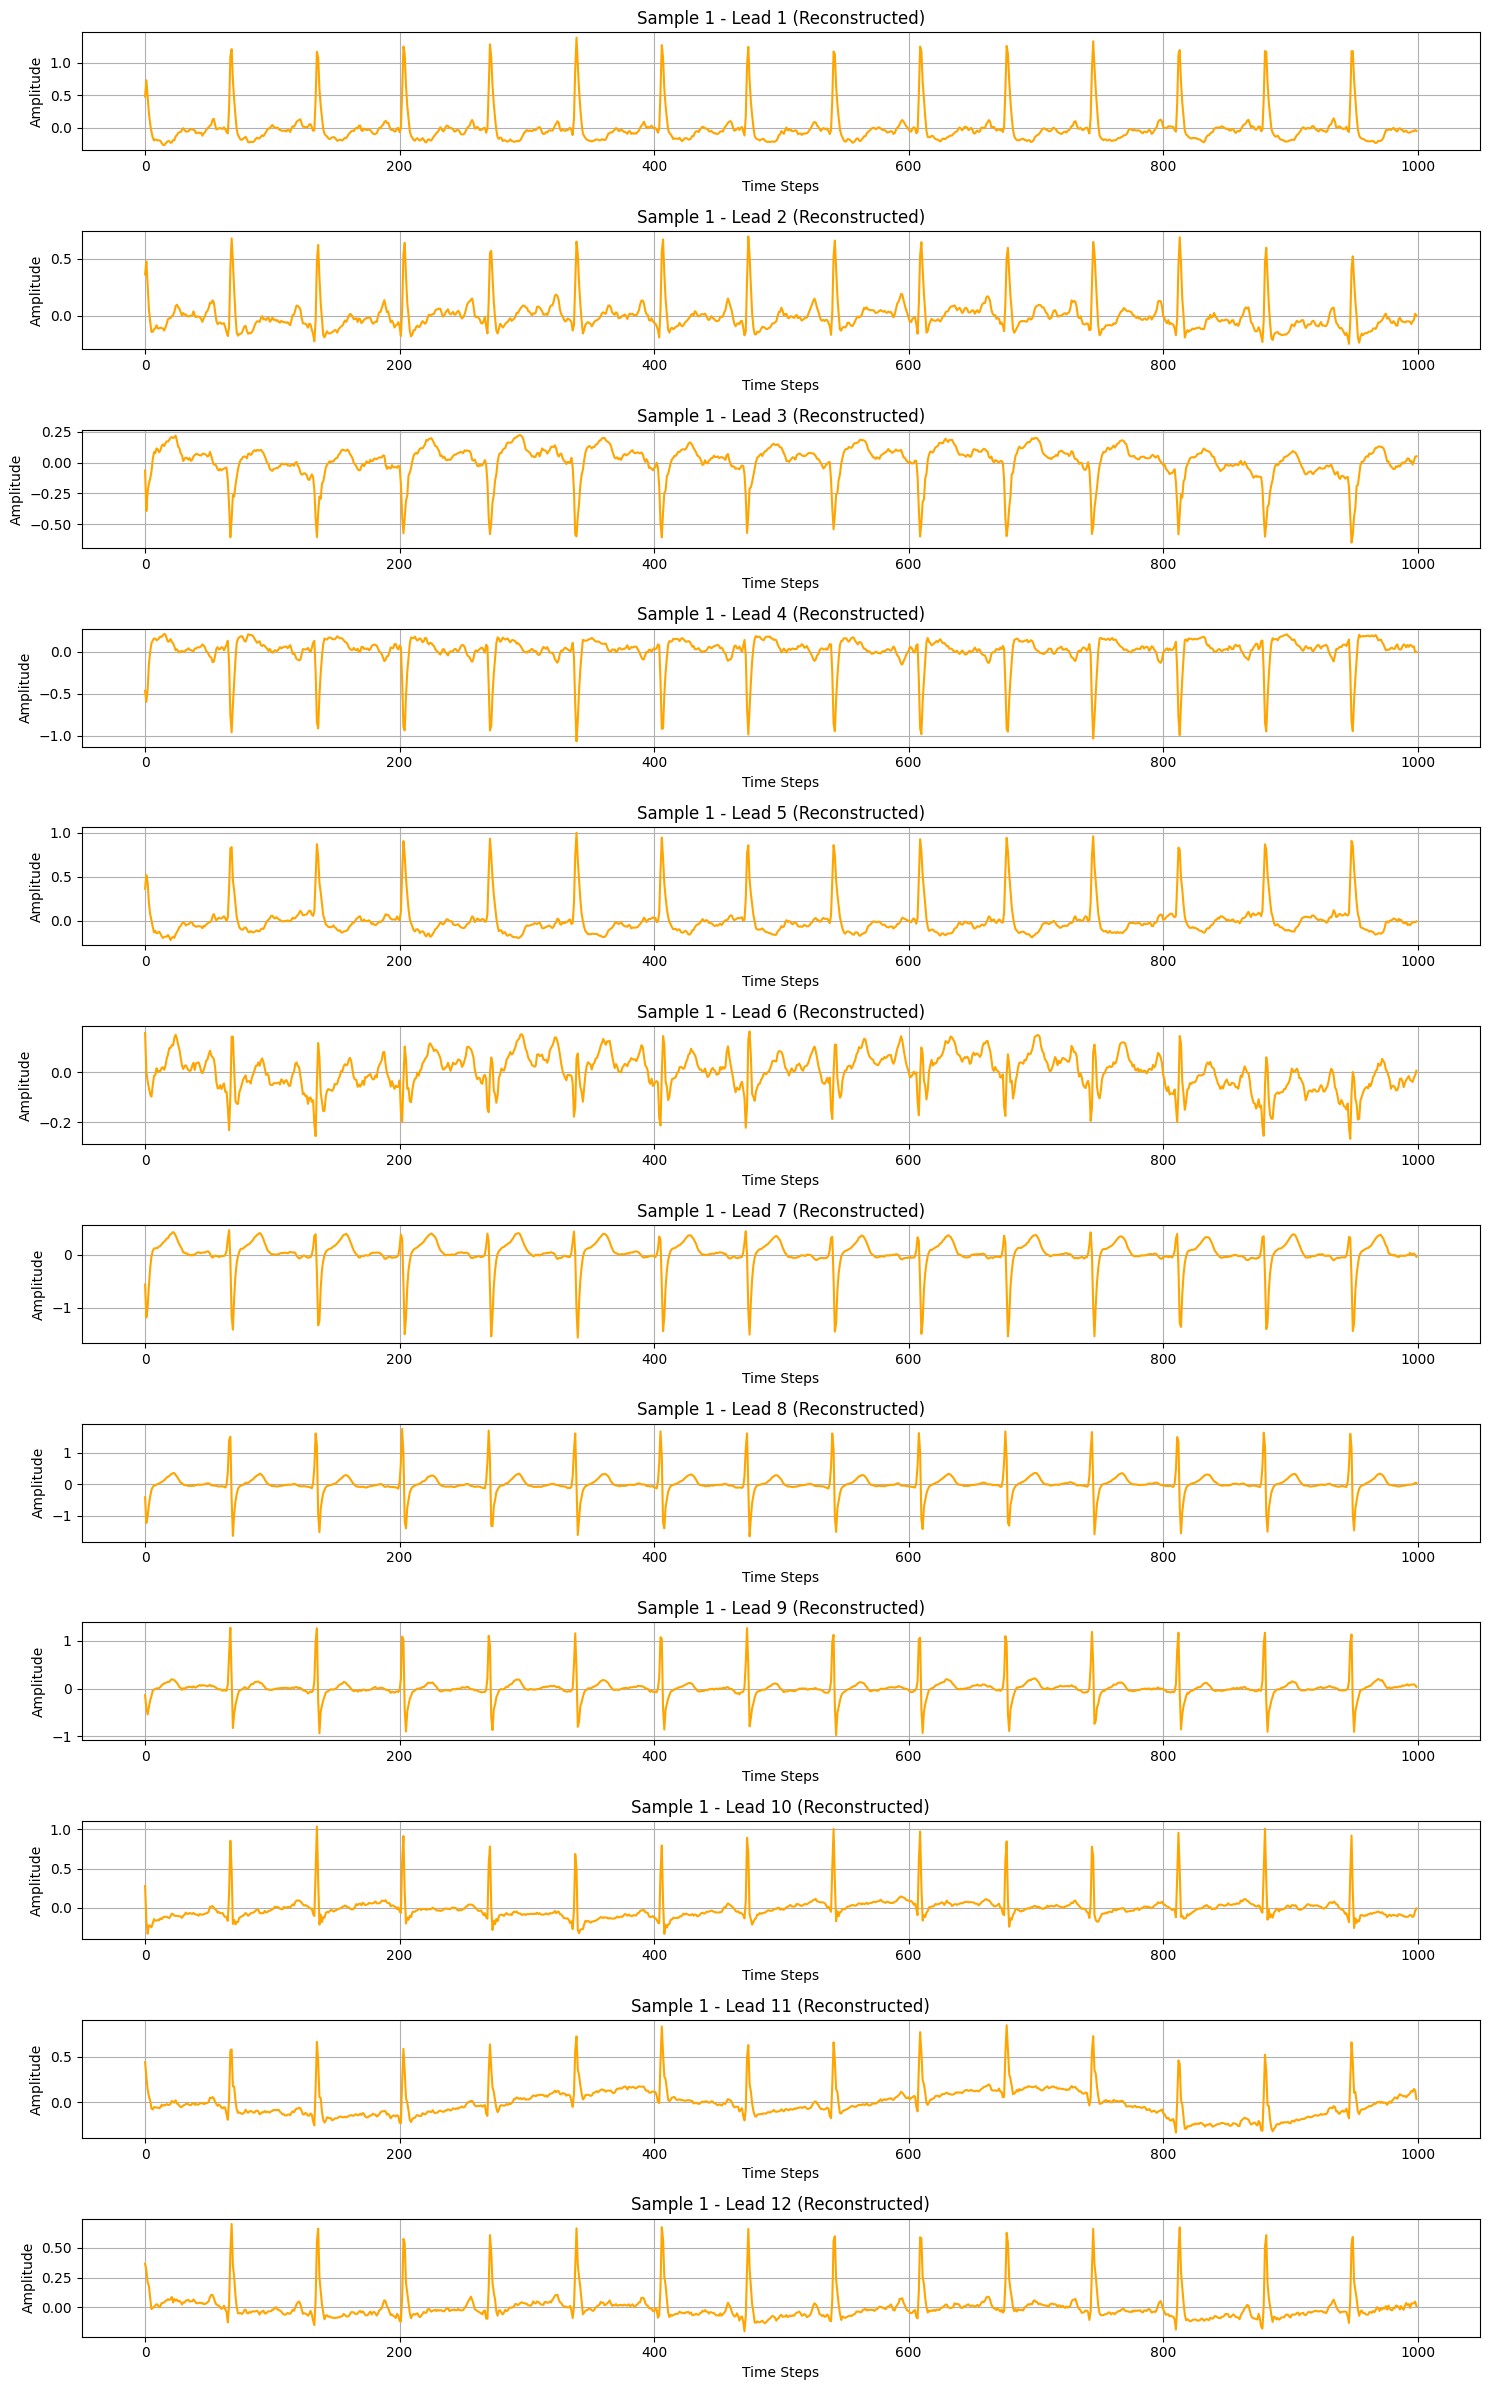

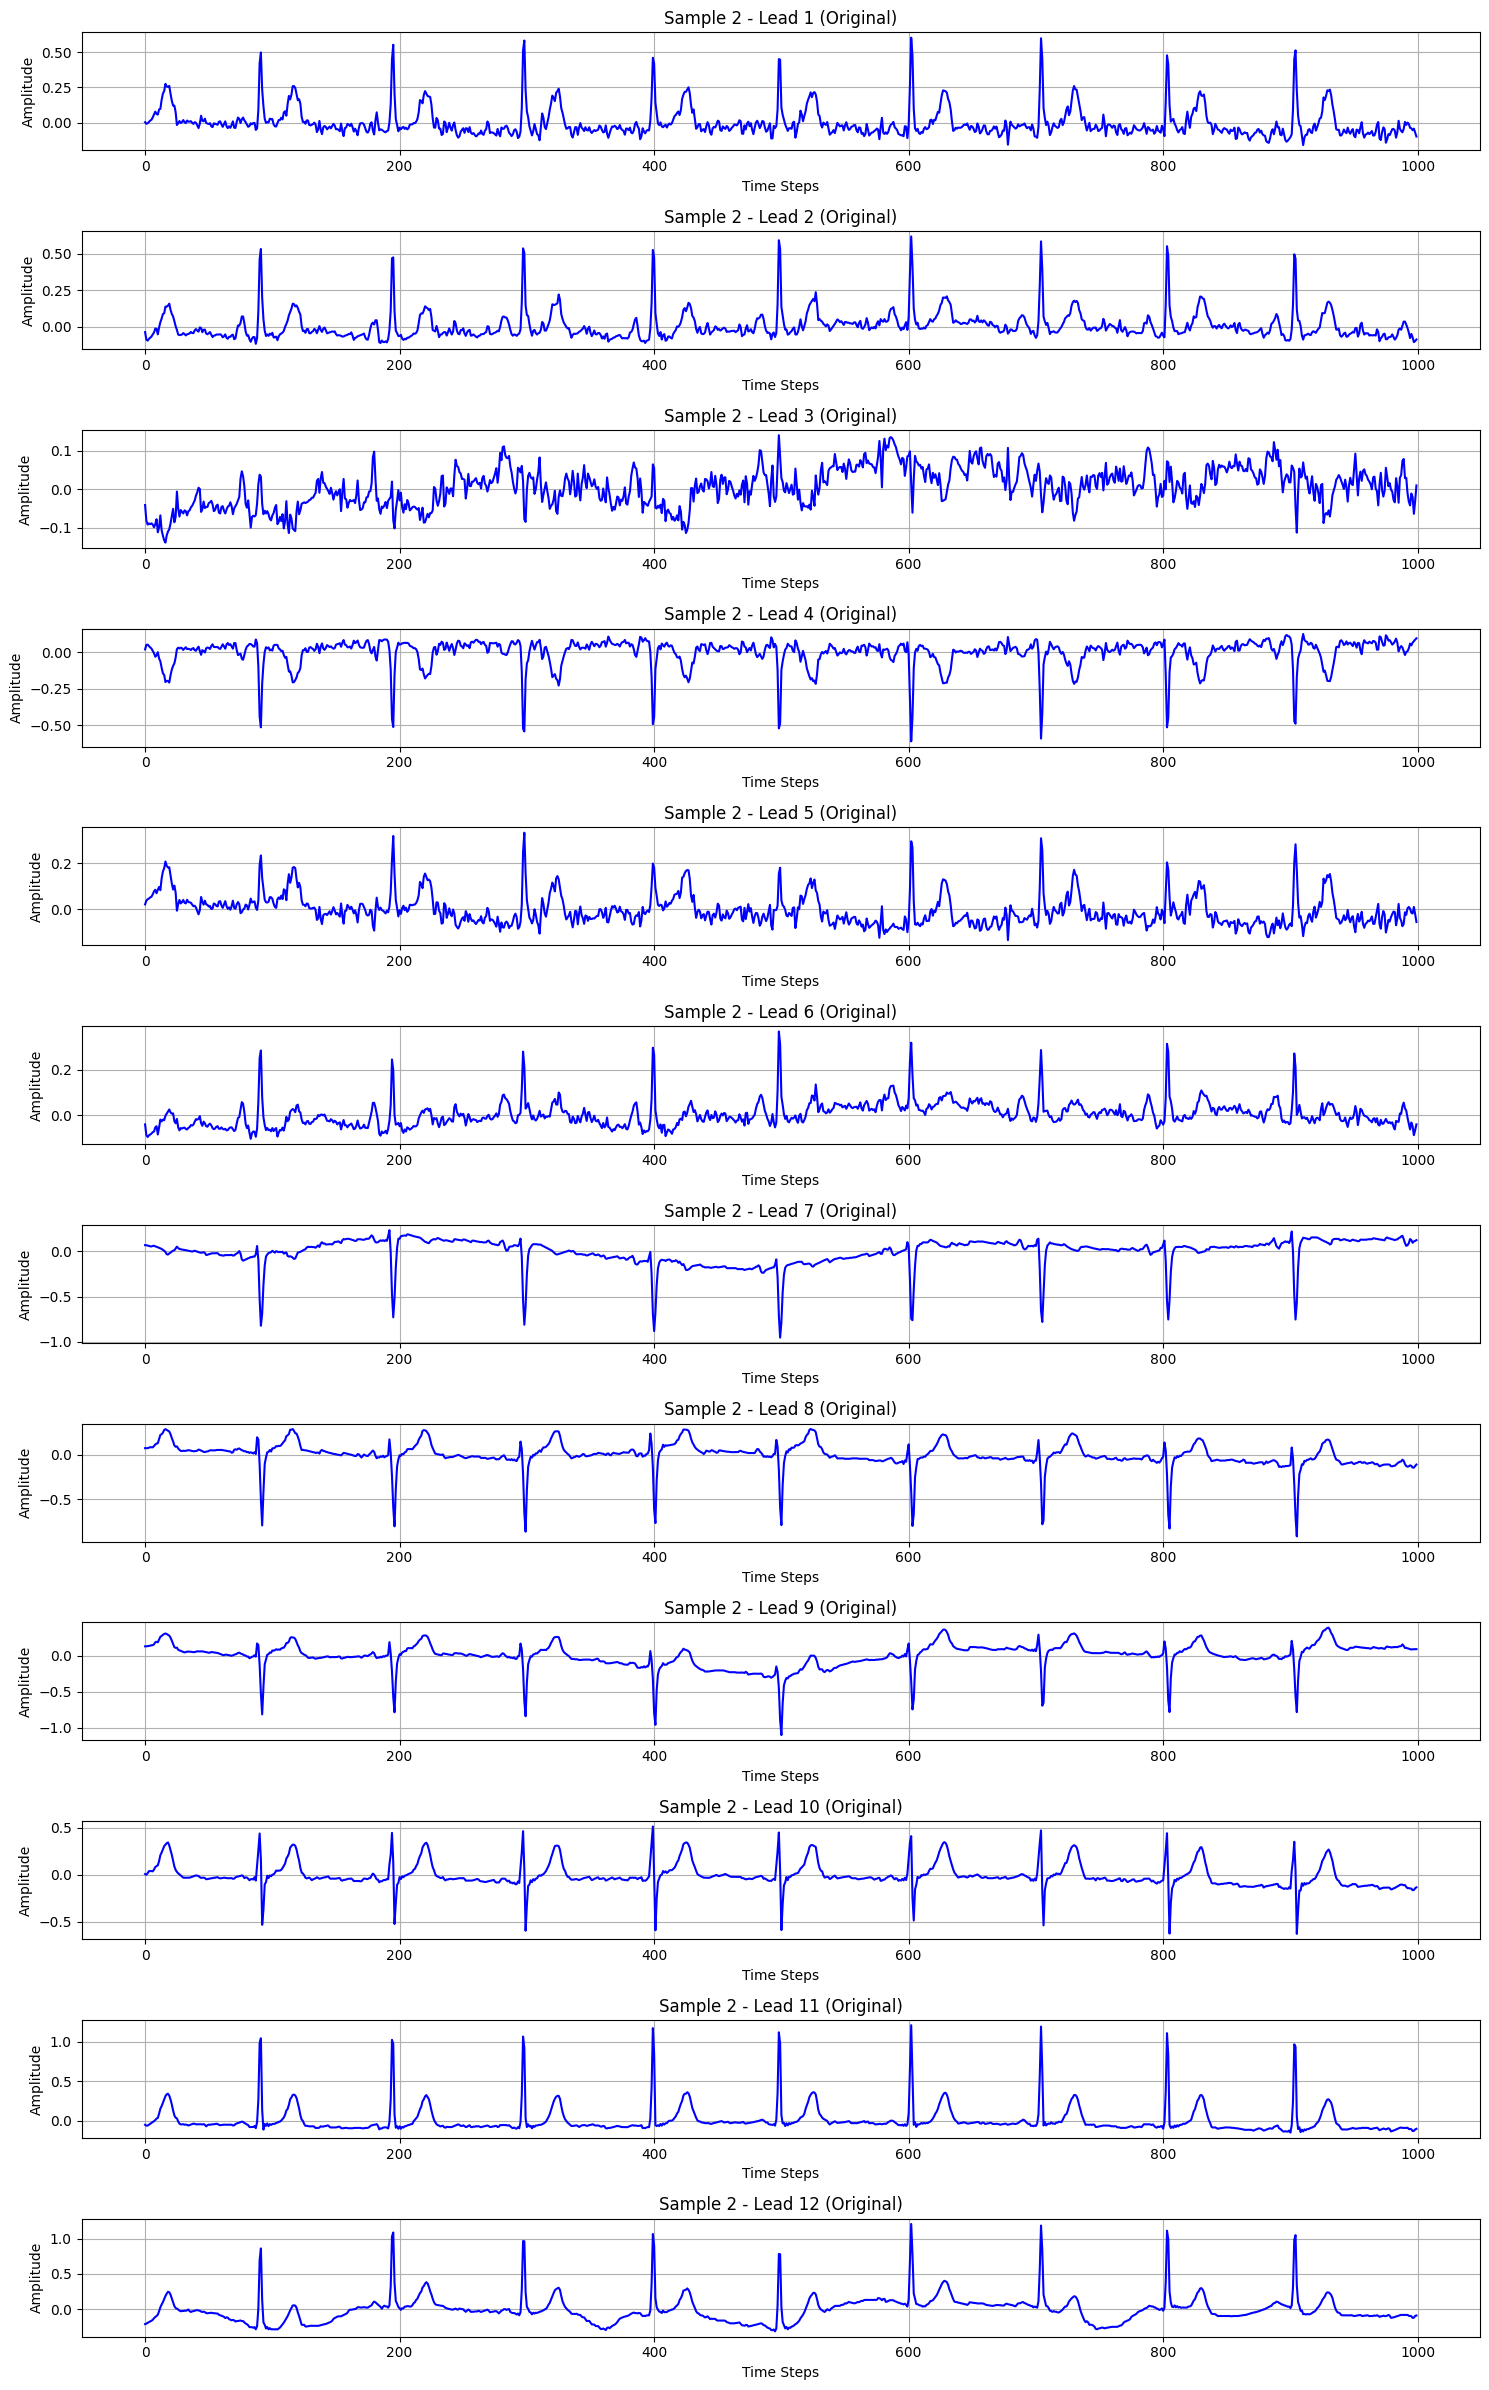

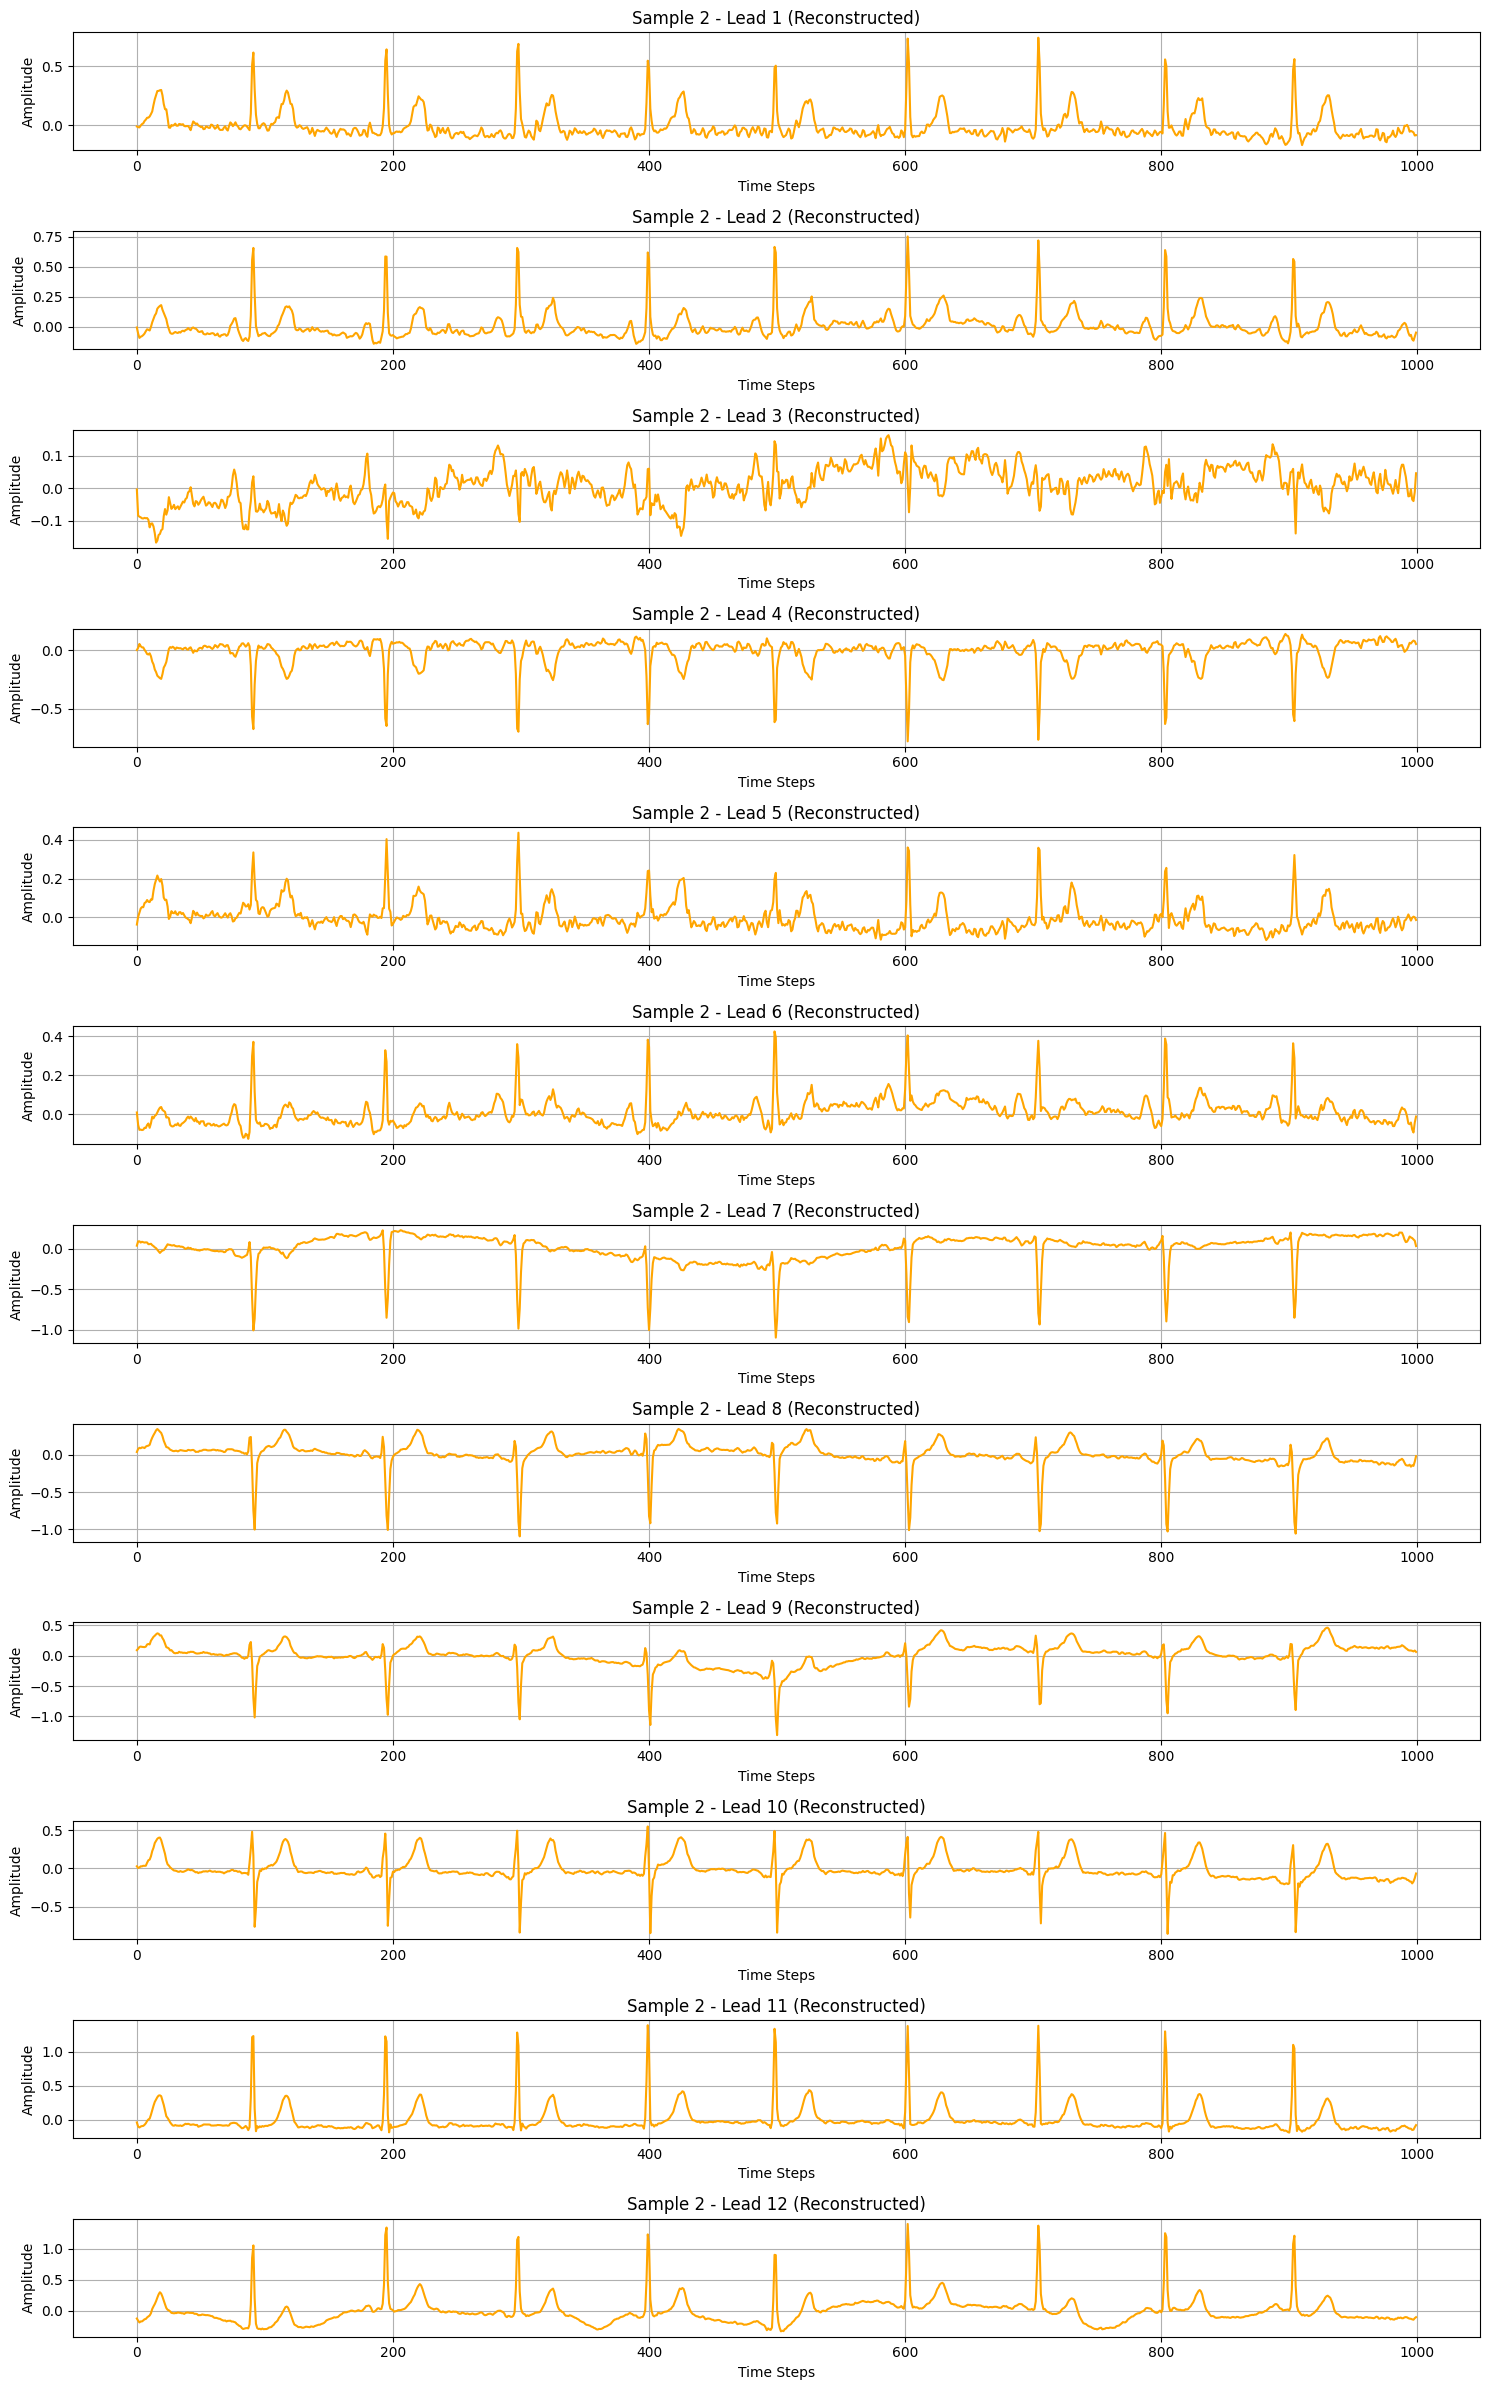

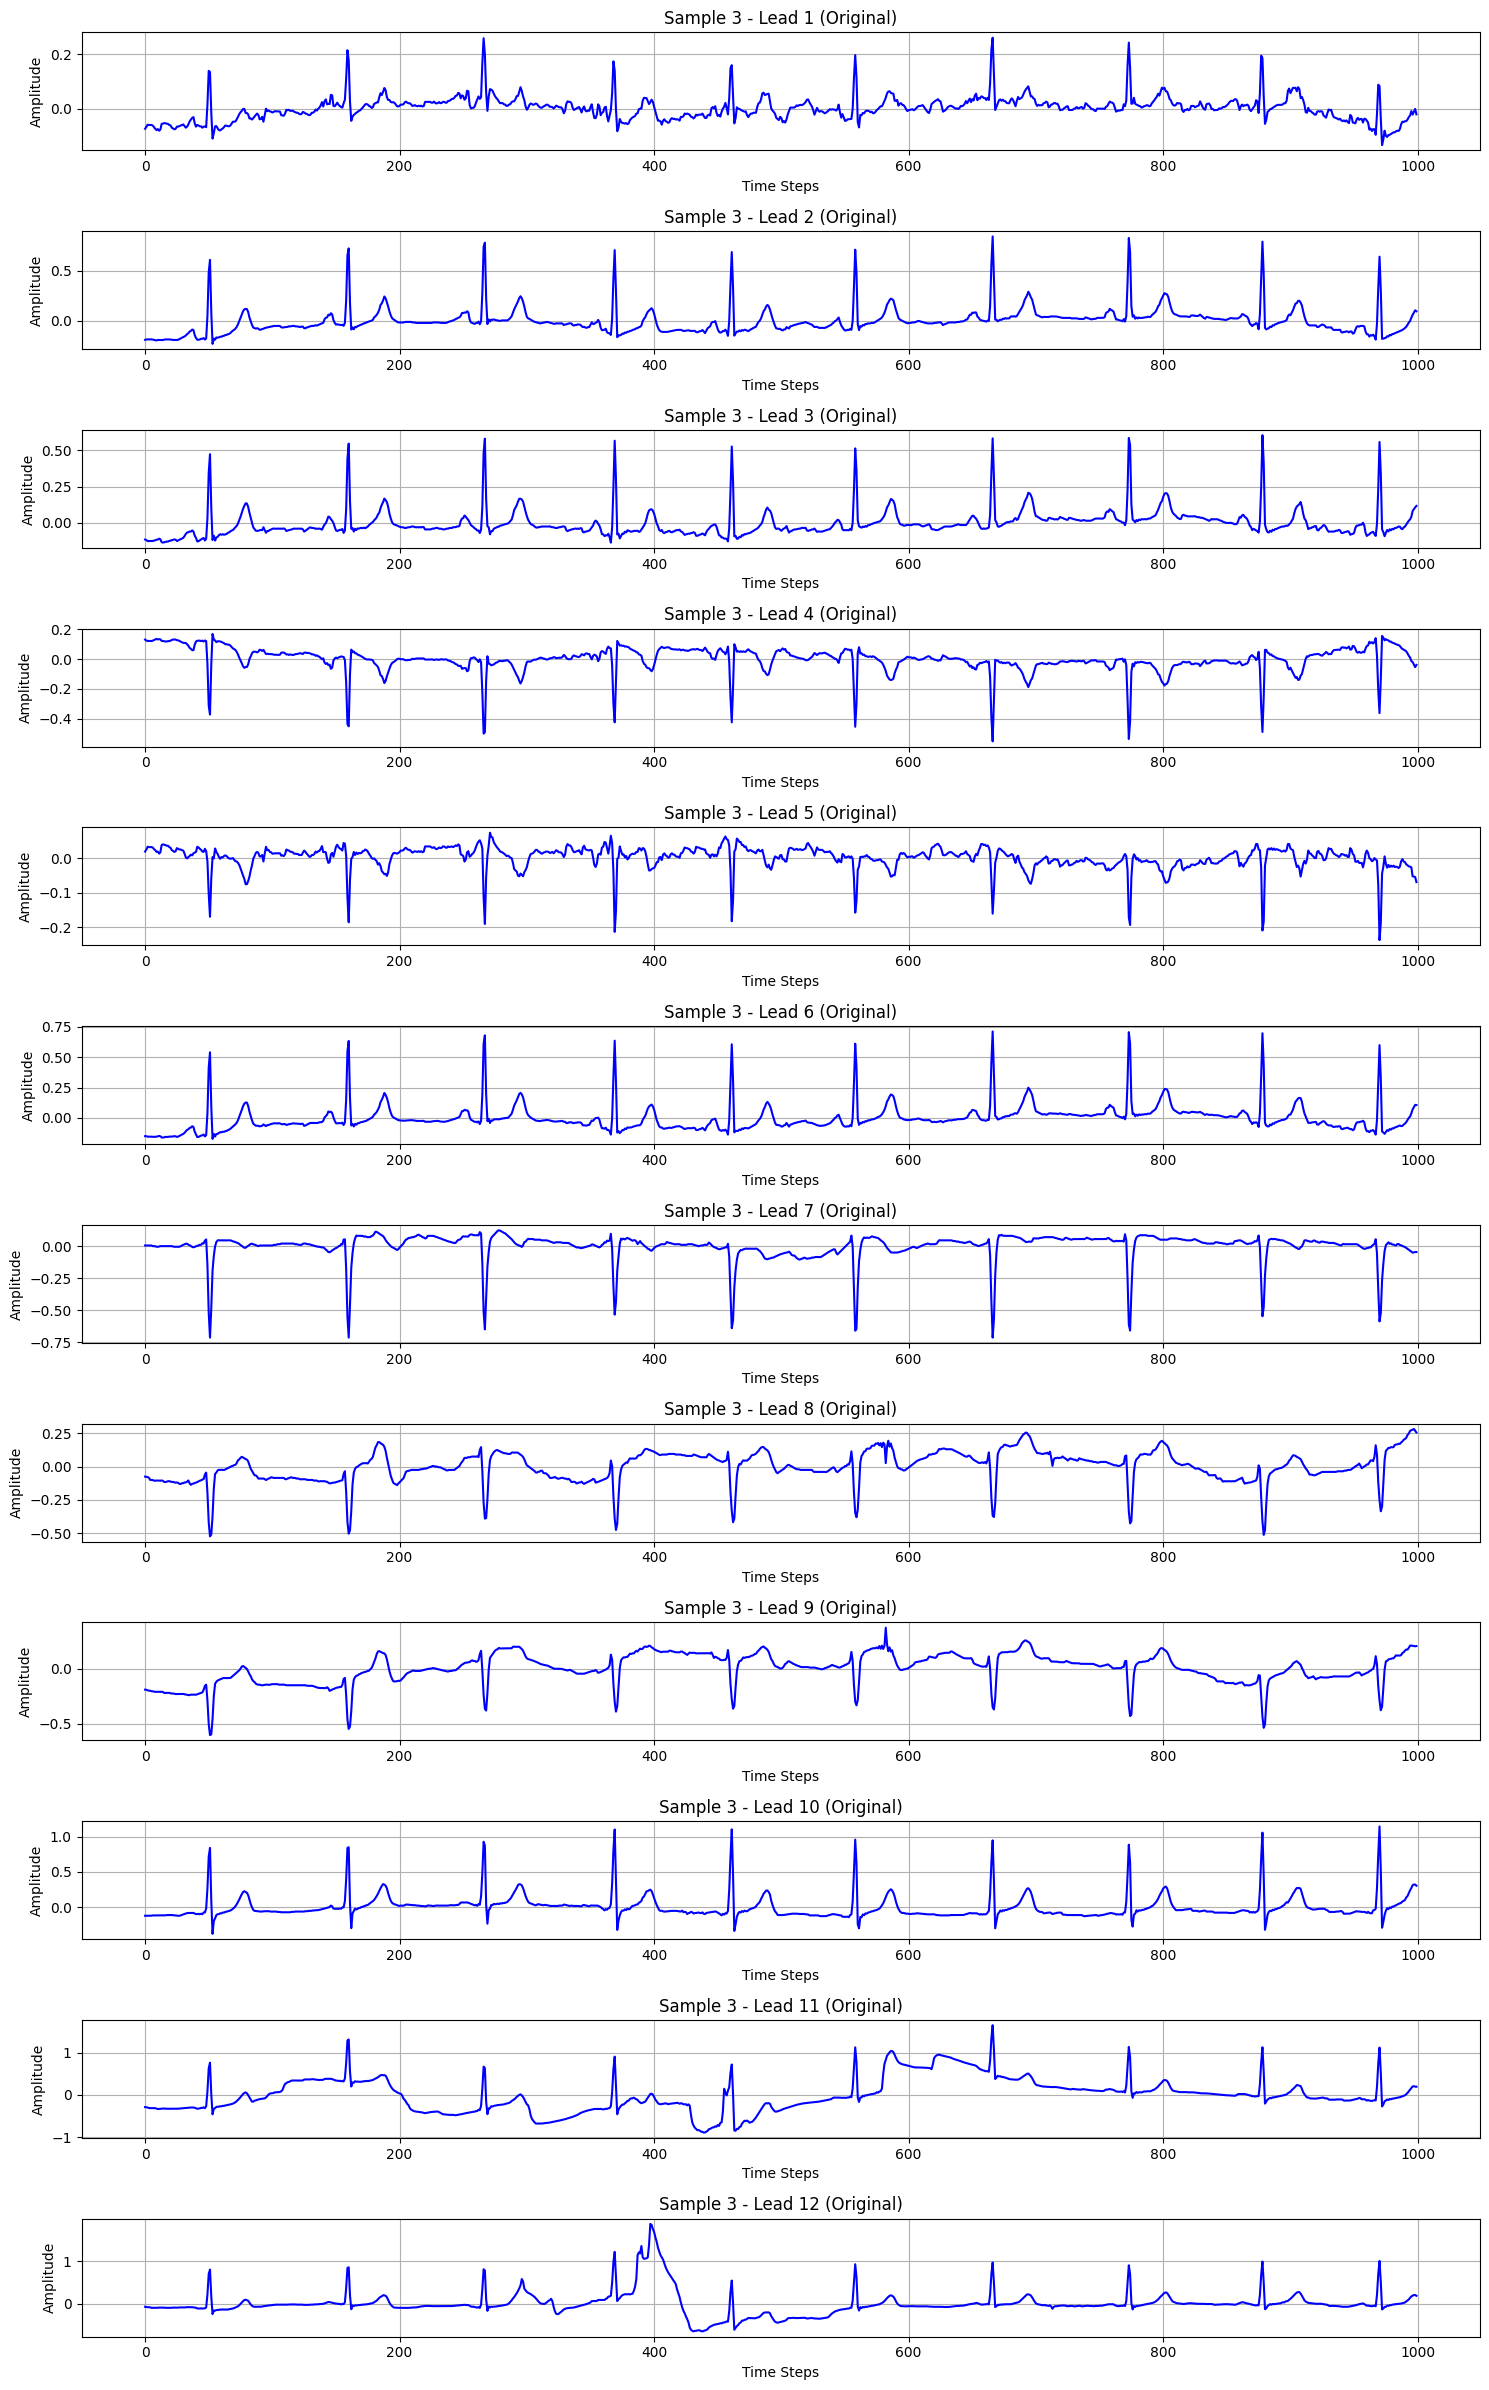

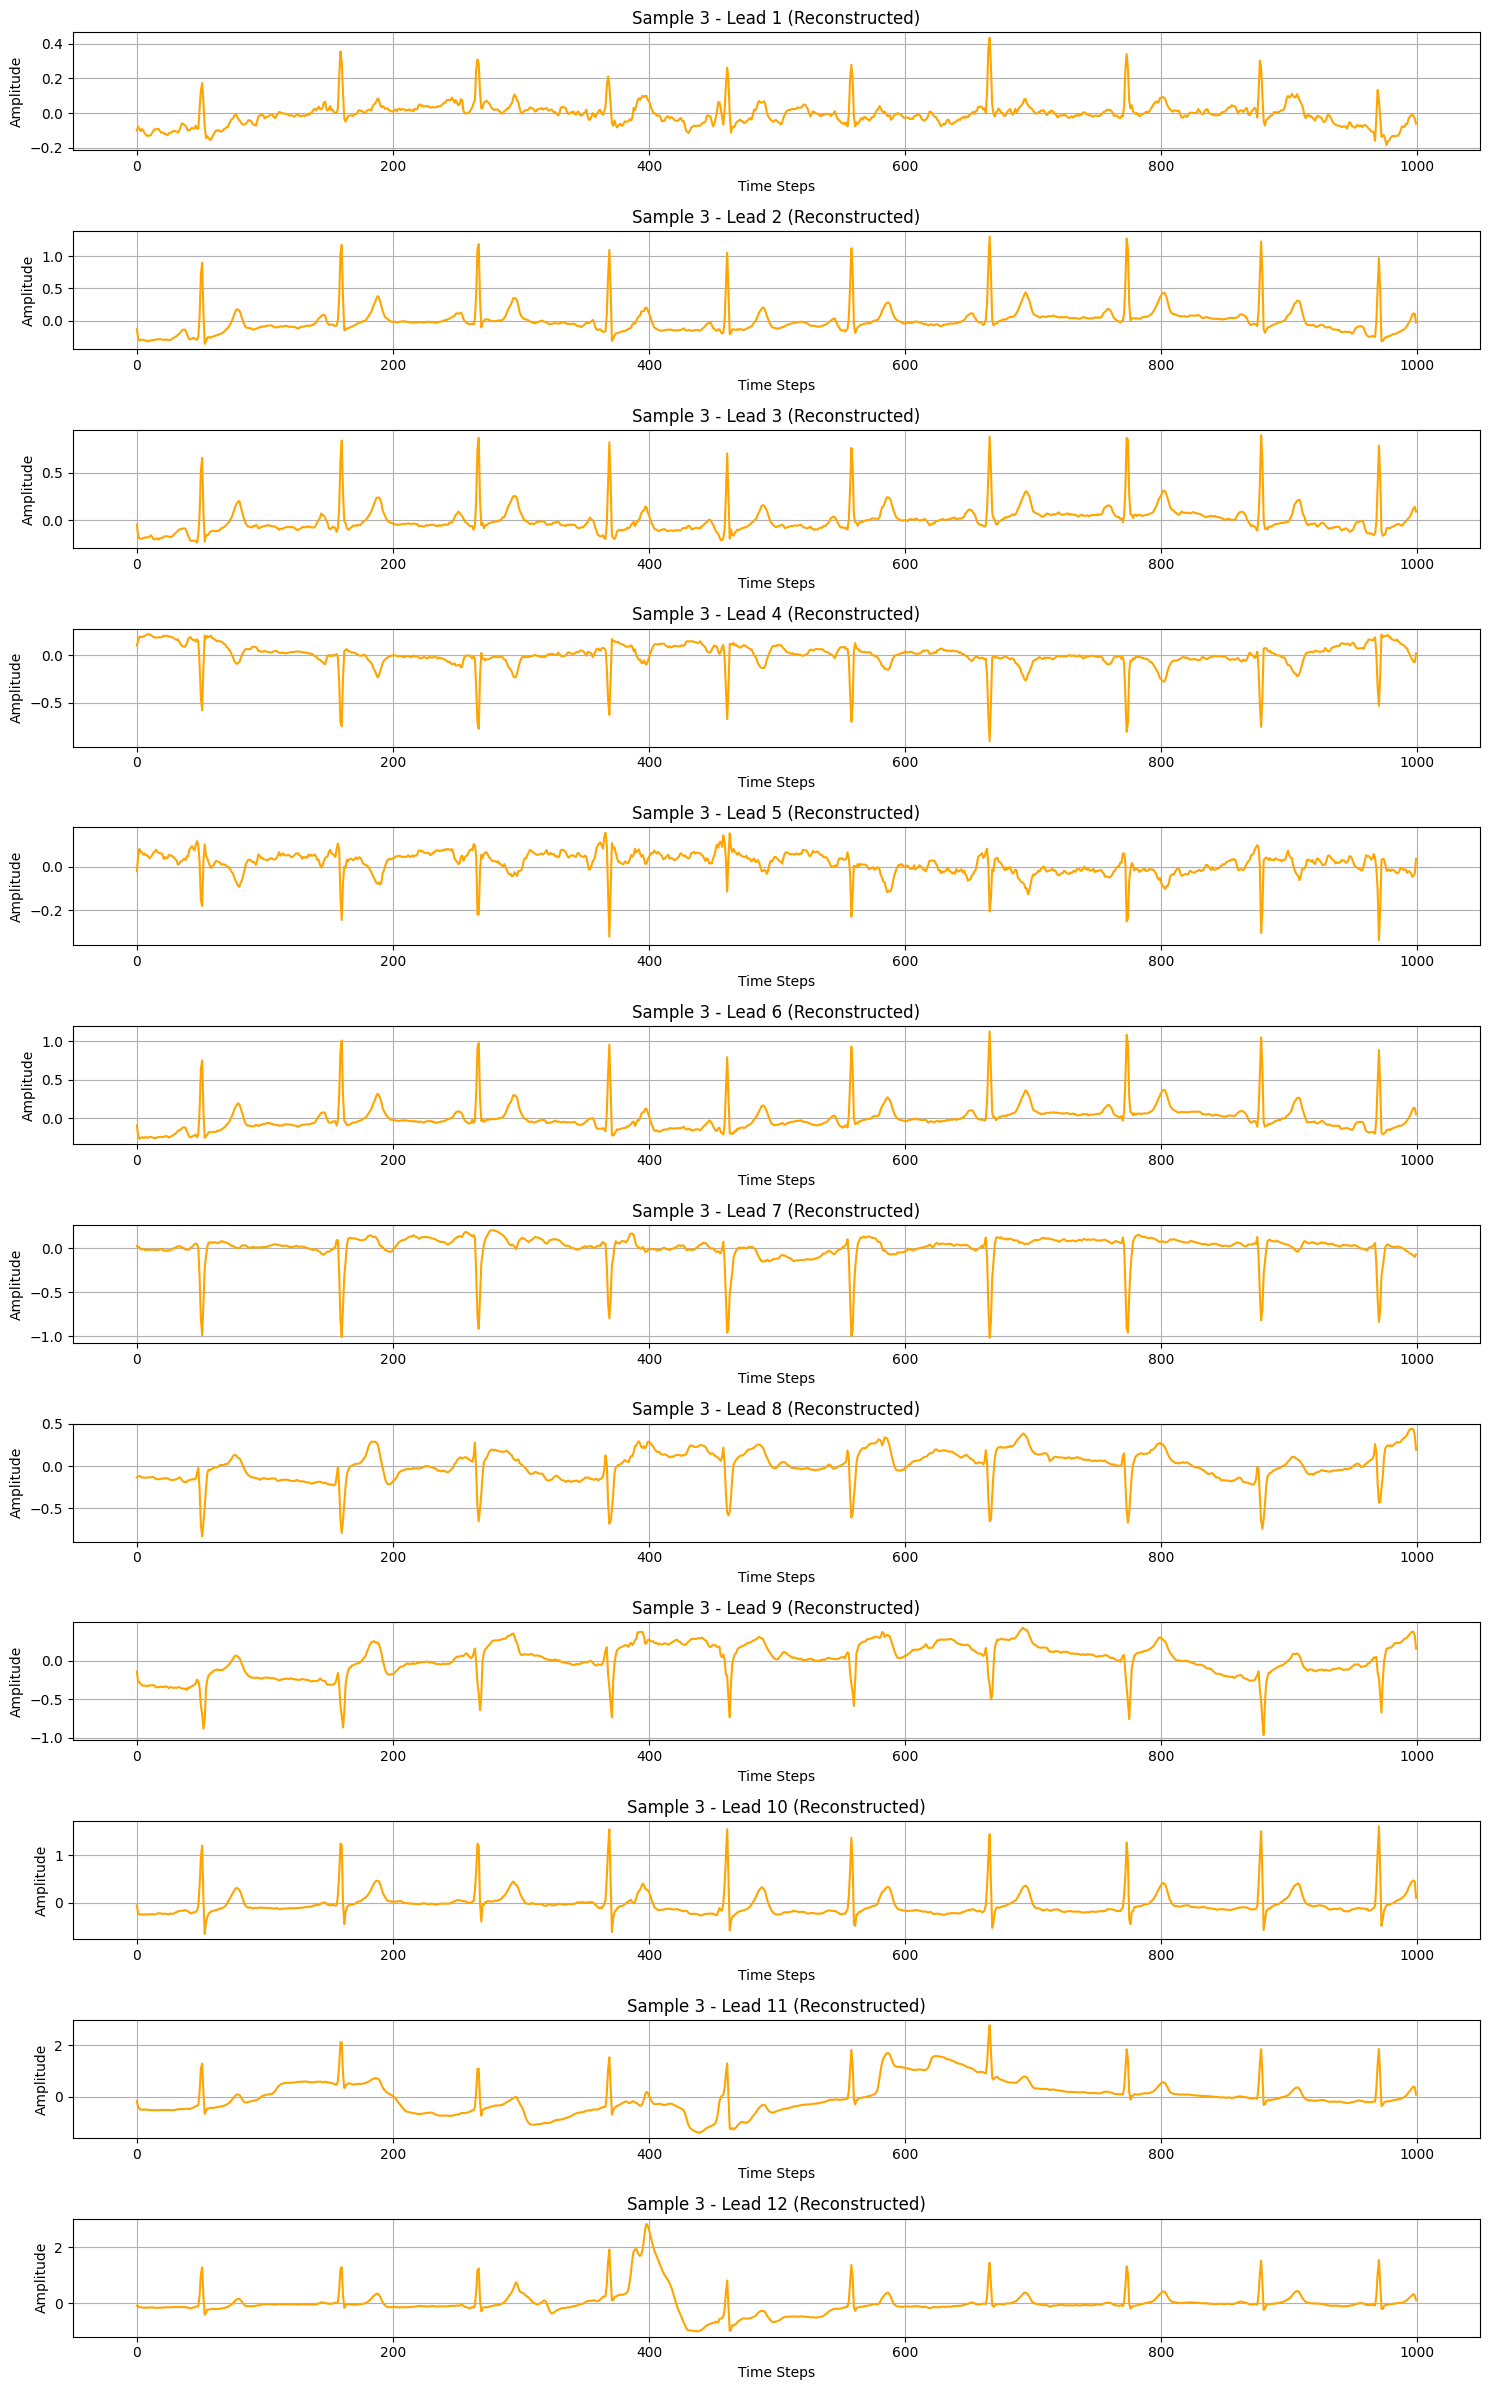

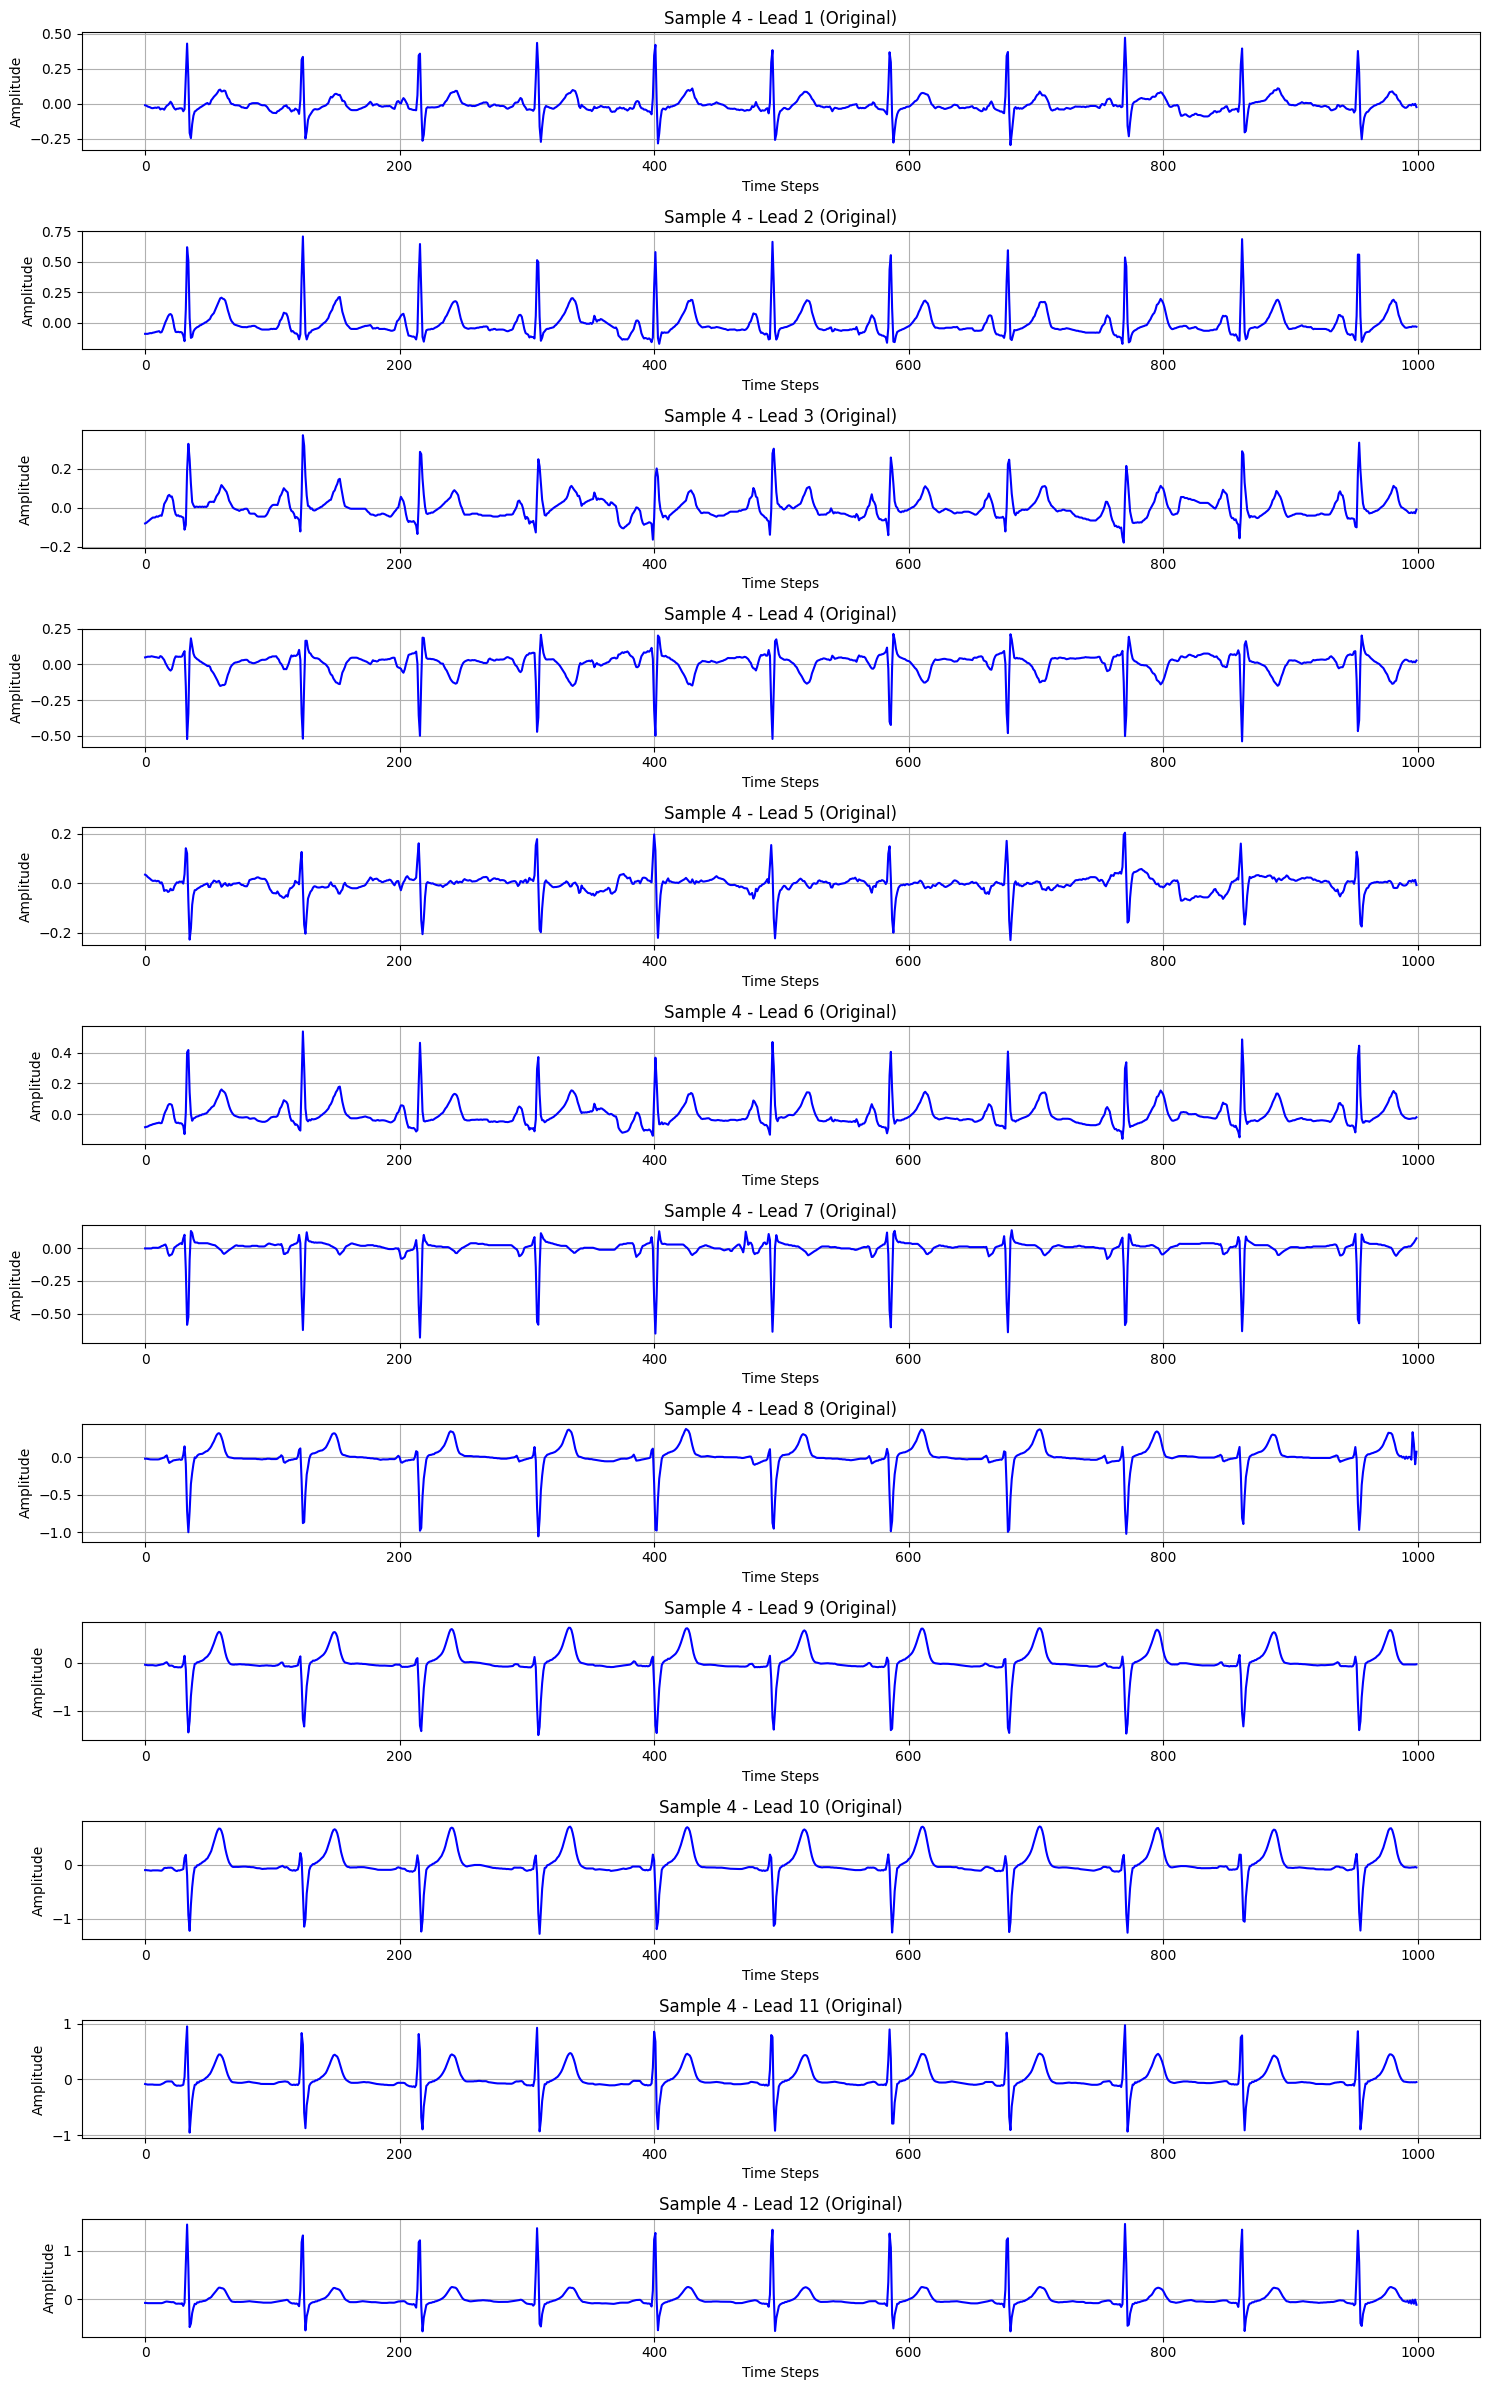

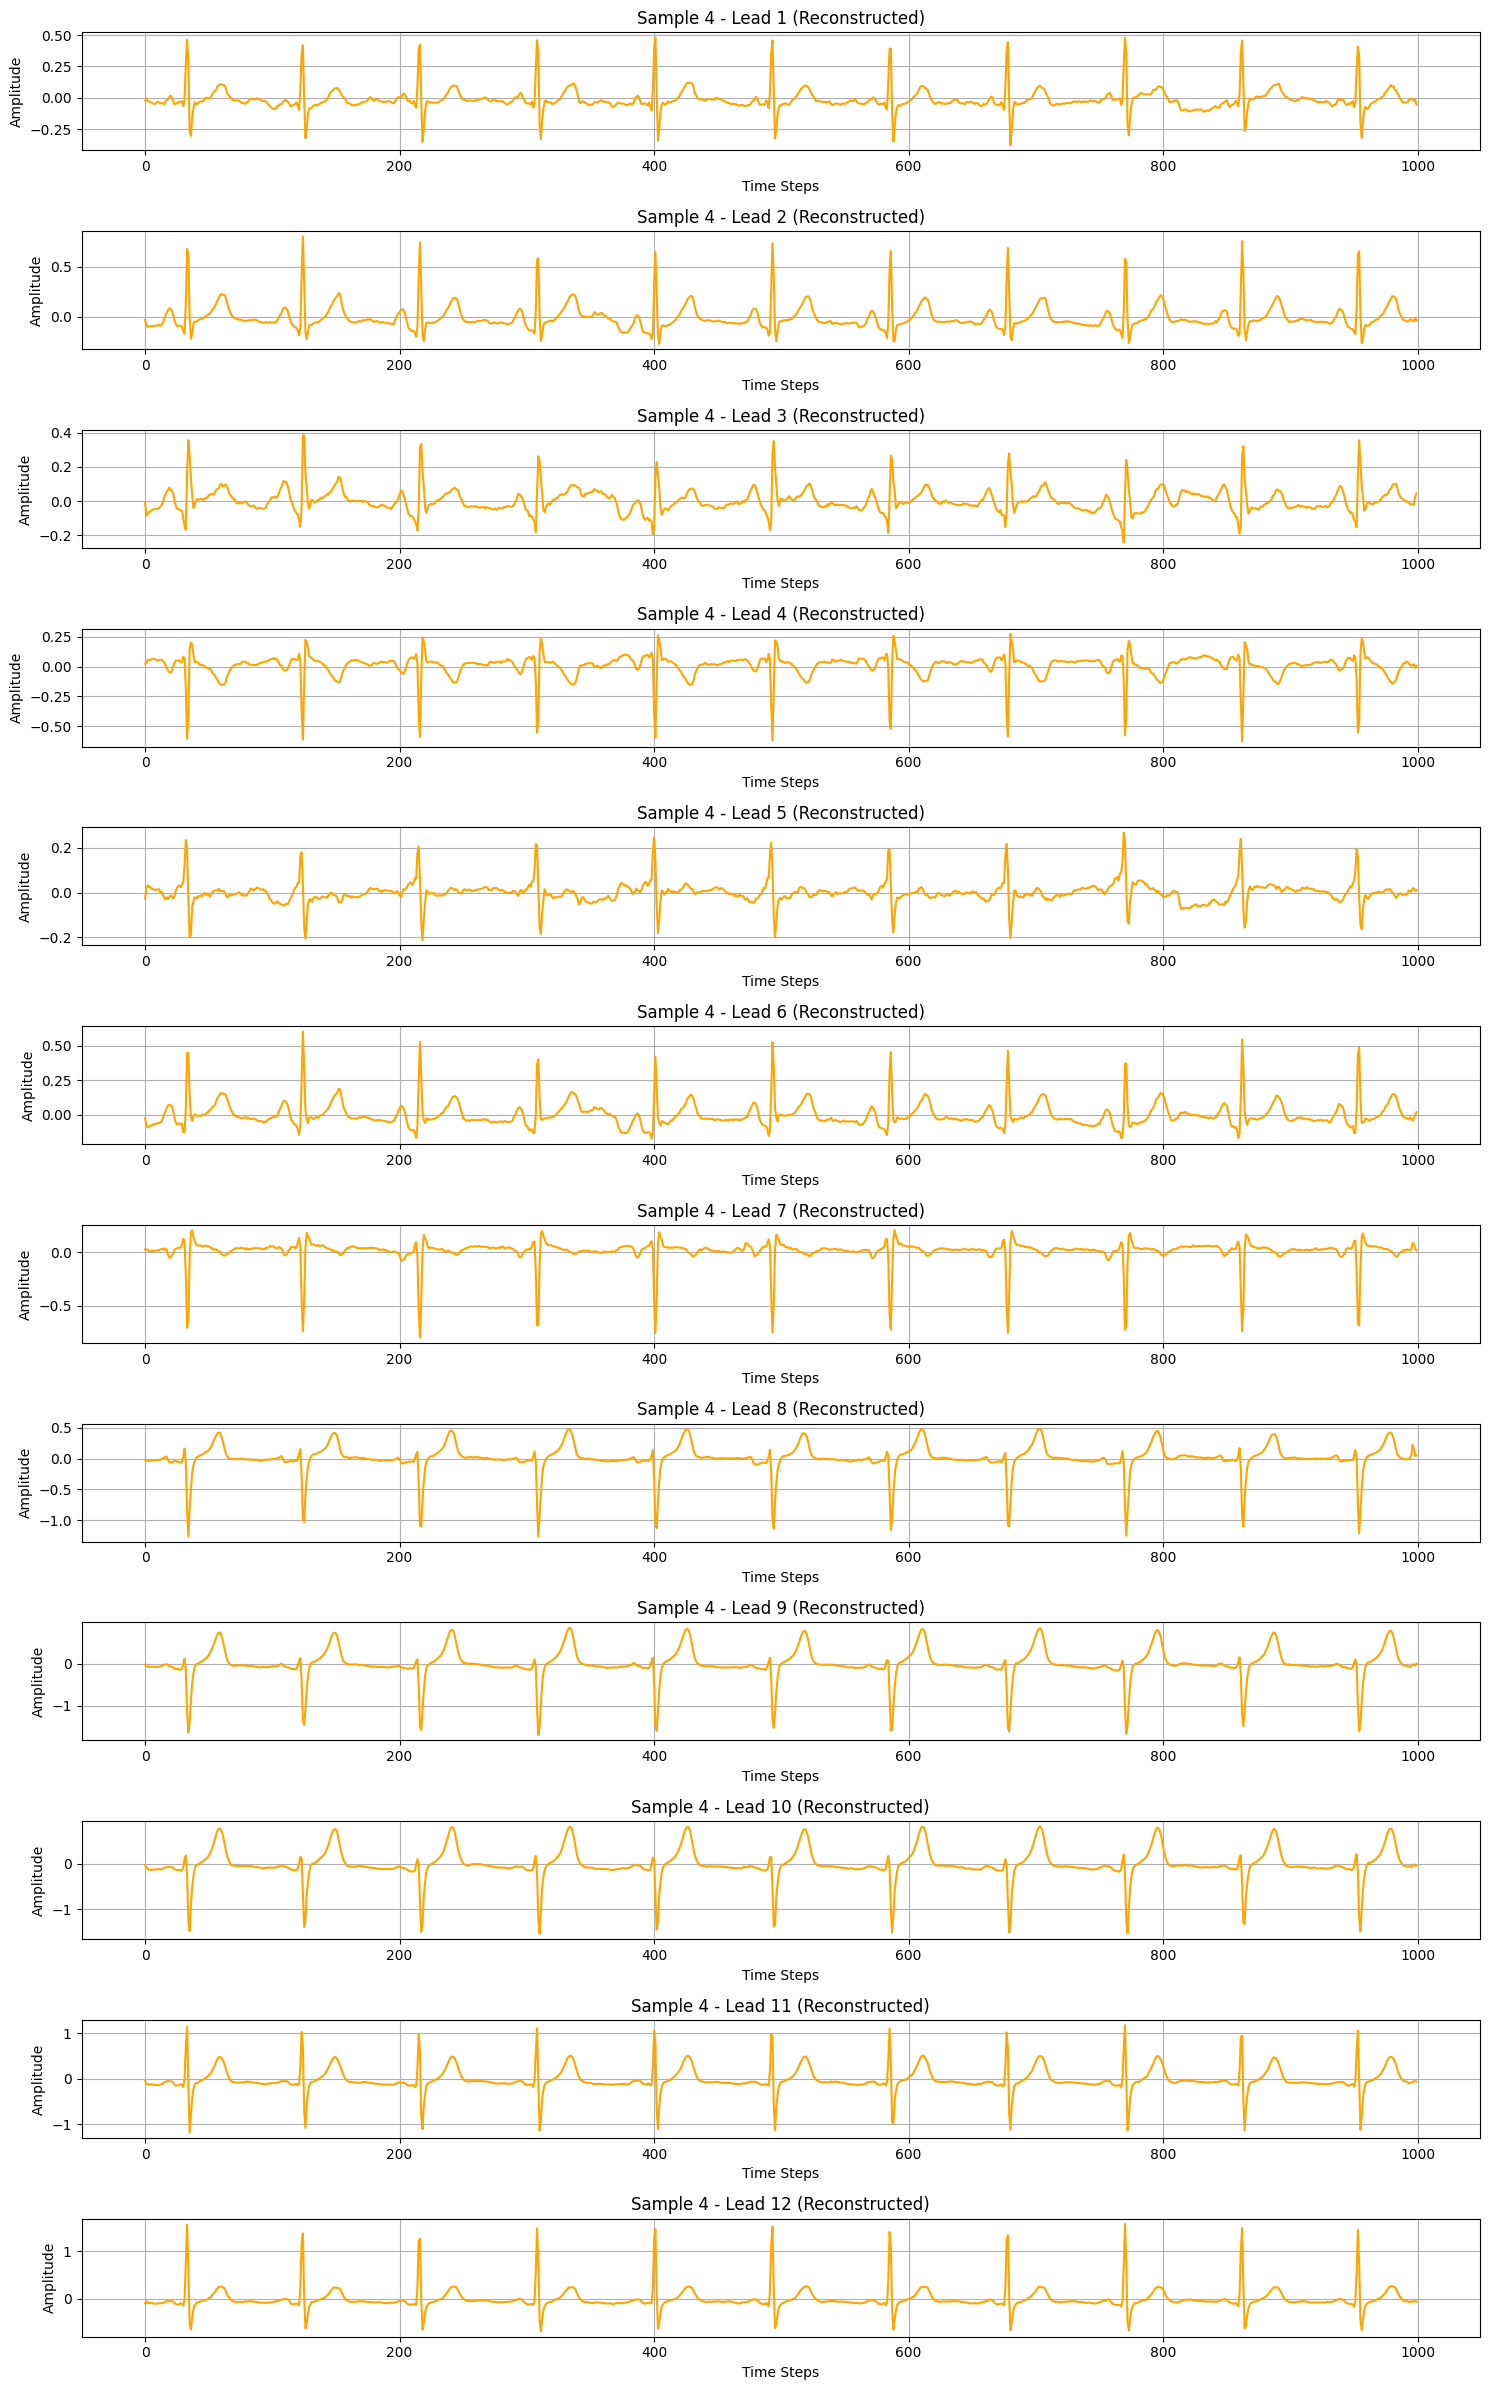

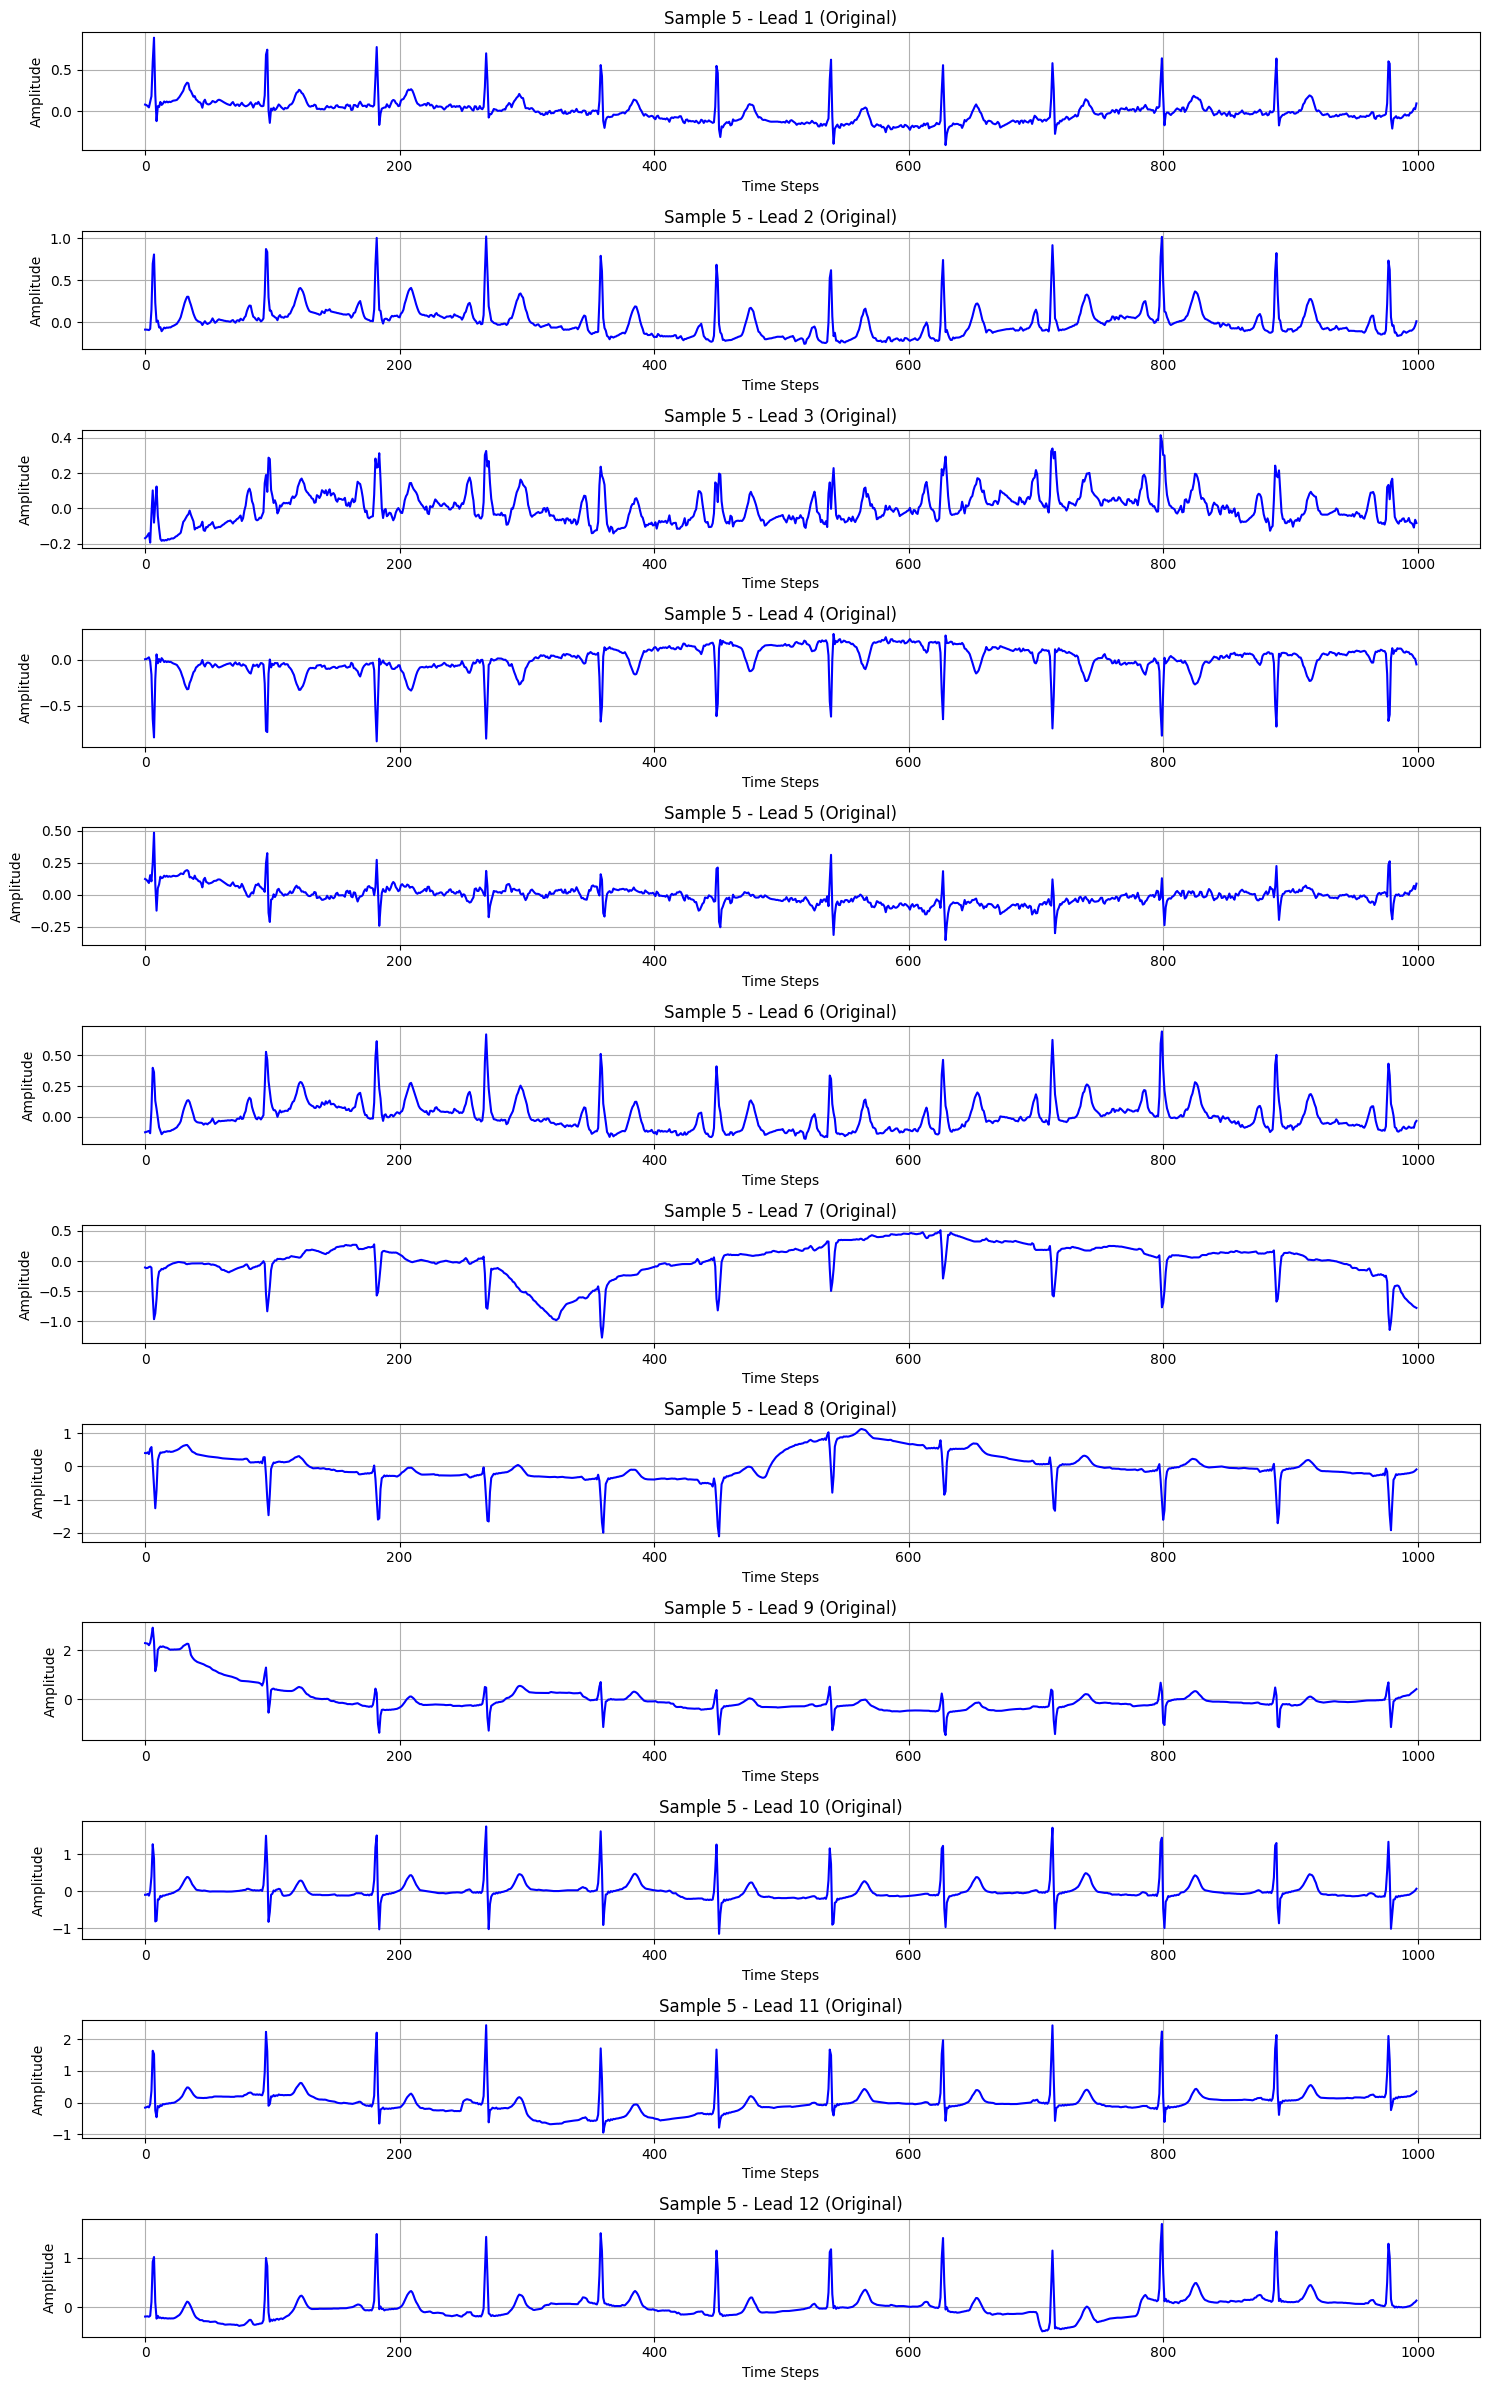

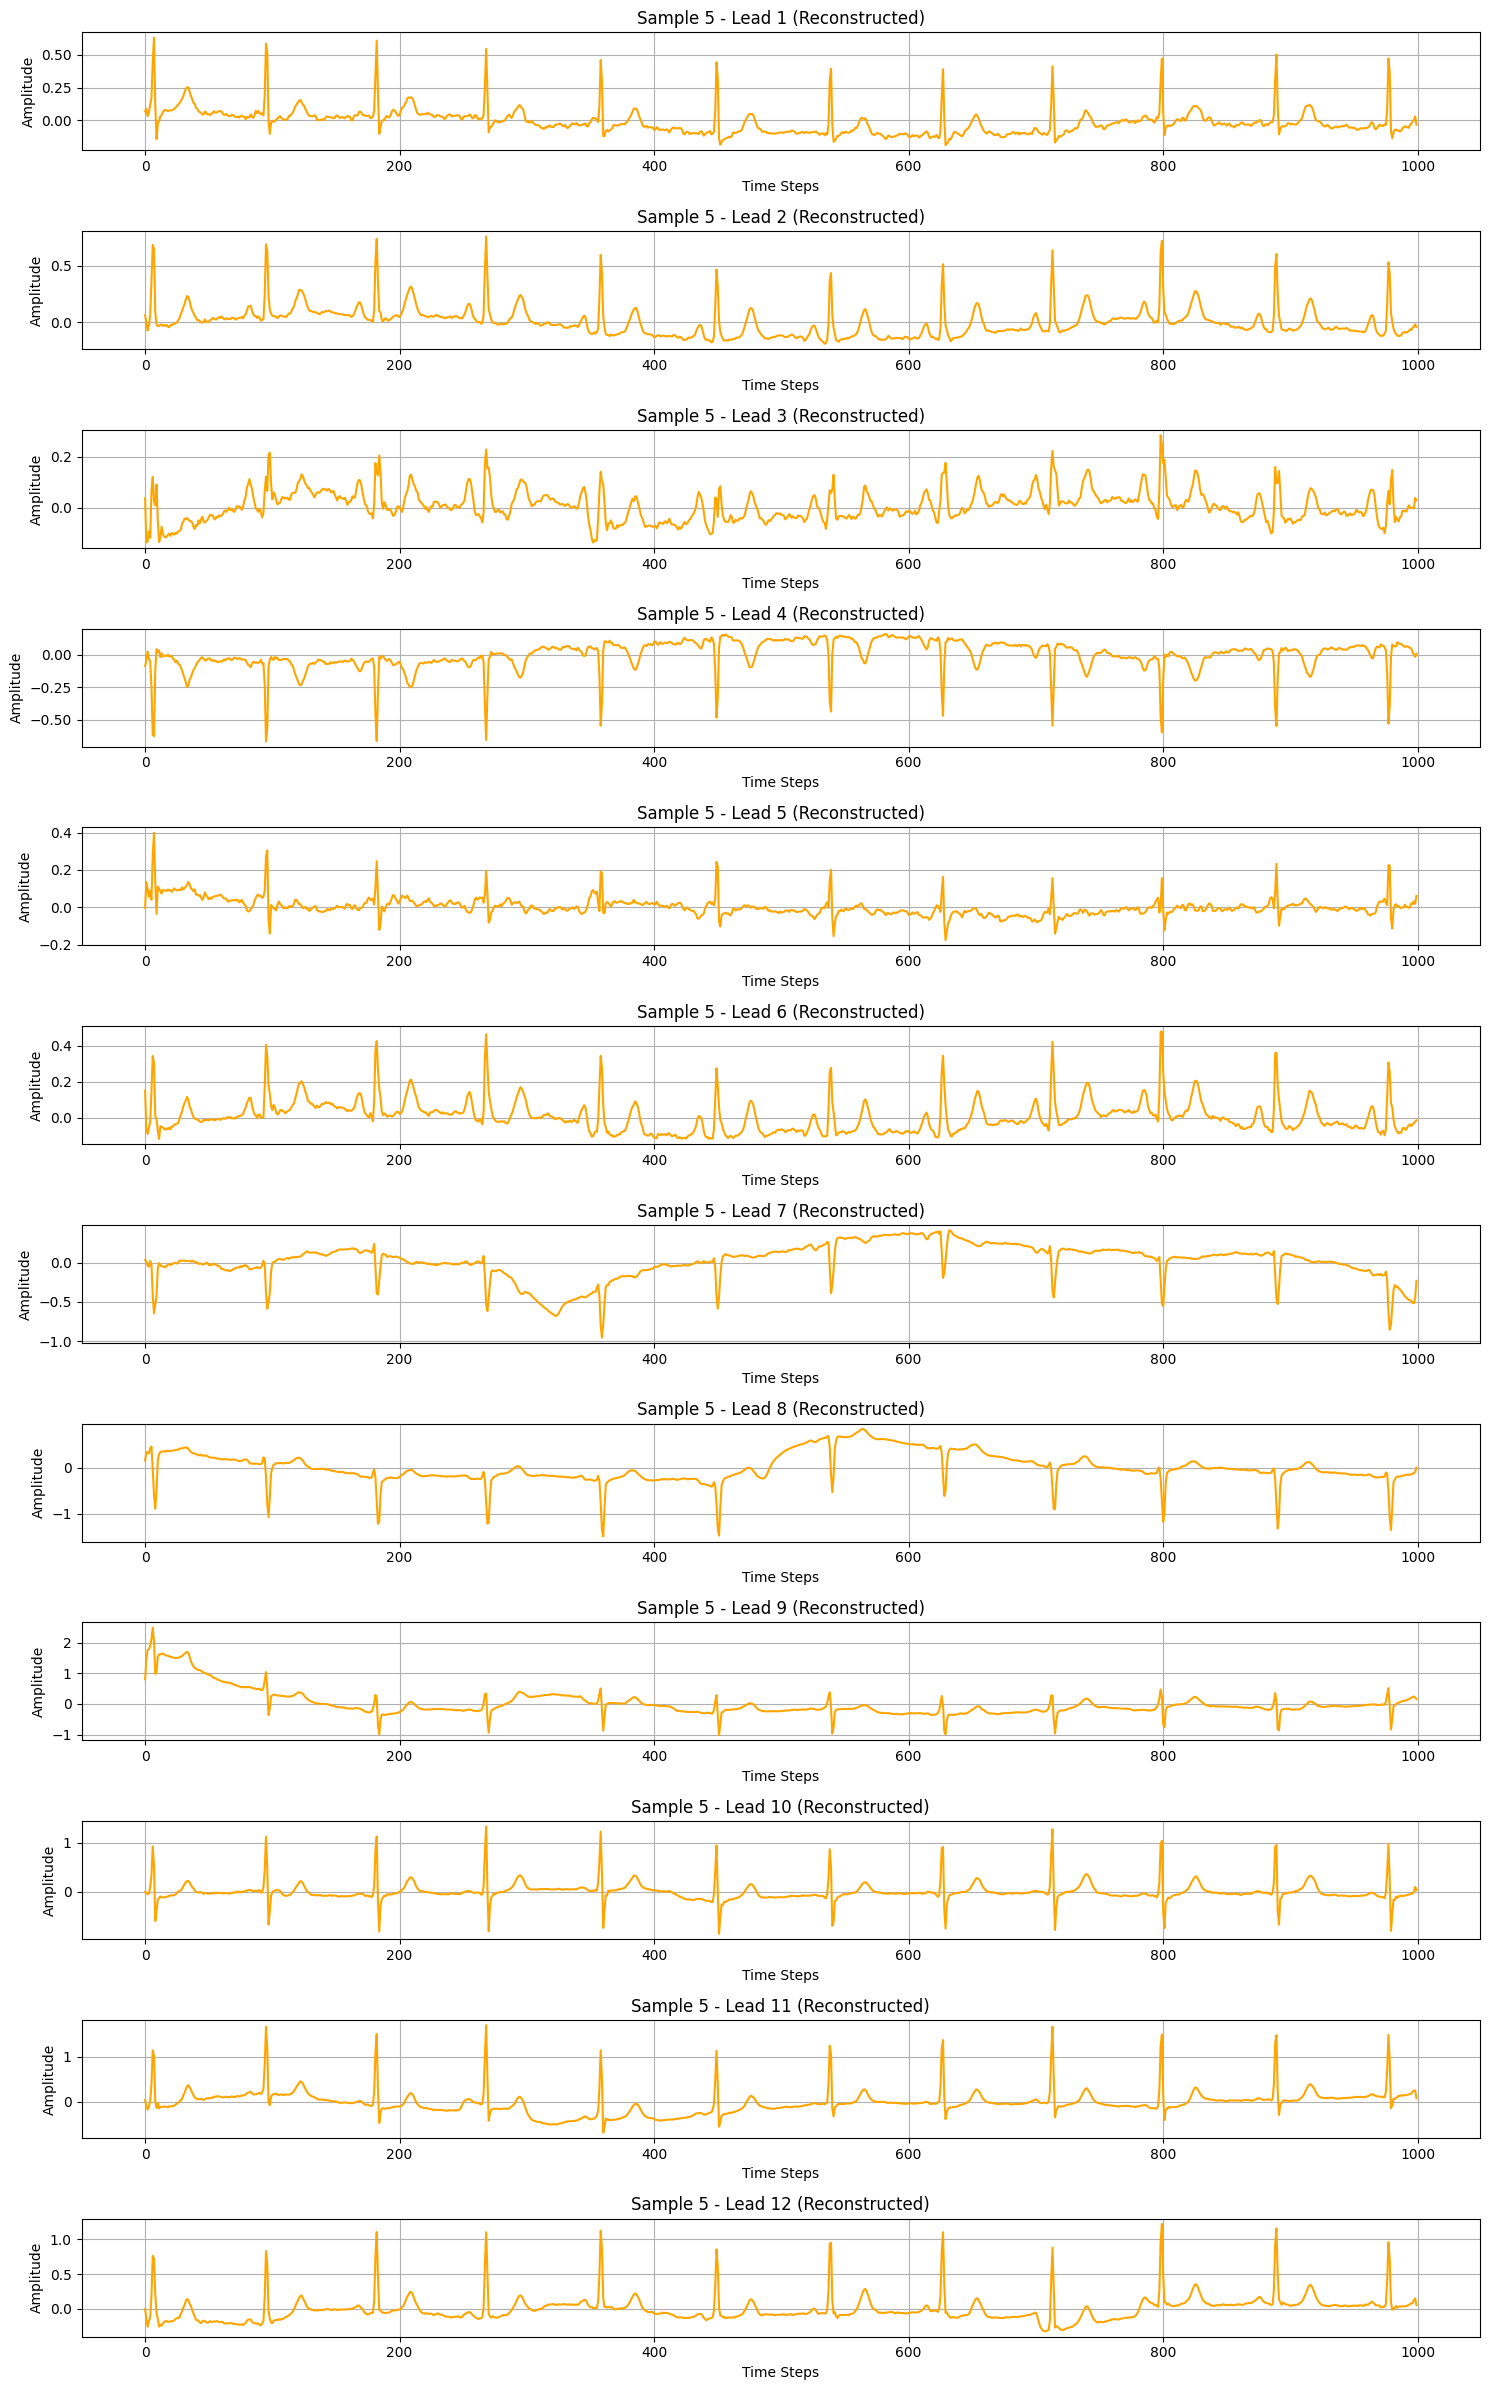

In [31]:
# Sample some original data
sample_indices = np.random.choice(len(X_train), size=5, replace=False)
original_samples = X_train_tensor[sample_indices]  # Get original samples

# Convert to PyTorch tensor and move to device
original_samples = original_samples.to(device)  # Ensure it’s on the correct device
original_samples = original_samples.float()  # Ensure the tensor is of type float if needed

# Generate reconstructed samples
with torch.no_grad():
    try:
        # Create random noise tensor (same batch size, to device)
        random_noise = torch.randn(original_samples.shape[0], device=device)

        # Pass original_samples to the model
        reconstructed_samples = model(original_samples, random_noise).cpu().detach().numpy()
        print("Reconstructed sample shapes:", reconstructed_samples.shape)
    except Exception as e:
        print(f"Error during reconstruction: {e}")

# Plotting
# Plotting lead-wise samples sequentially
num_samples = len(original_samples)  # Number of samples to plot
num_leads = original_samples.shape[1]  # Assuming shape is (batch_size, num_leads, sequence_length)

# Create a figure for each sample
for i in range(num_samples):
    plt.figure(figsize=(15, 2 * num_leads))  # Set the figure size based on the number of leads

    for lead in range(num_leads):
        # Original sample plot
        plt.subplot(num_leads, 1, lead + 1)  # One subplot for each lead
        plt.plot(original_samples[i, lead].cpu().numpy(), color='blue')  # Move to CPU
        plt.title(f"Sample {i + 1} - Lead {lead + 1} (Original)")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.grid(True)

    plt.tight_layout()
    plt.show()  # Show original sample

    plt.figure(figsize=(15, 2 * num_leads))  # Create a new figure for reconstructed samples

    for lead in range(num_leads):
        # Reconstructed sample plot
        plt.subplot(num_leads, 1, lead + 1)  # One subplot for each lead
        plt.plot(reconstructed_samples[i, lead], color='orange')  # Use directly if it's NumPy
        plt.title(f"Sample {i + 1} - Lead {lead + 1} (Reconstructed)")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.grid(True)

    plt.tight_layout()
    plt.show()  # Show reconstructed sample